In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from matplotlib import colors as mcolors
from ultranest.utils import resample_equal
from scipy.interpolate import interp1d
import scipy.stats as stats
import ultranest.stepsampler
import itertools
from mpi4py import MPI
import gc
import time
import corner
import json

from my_functions import *

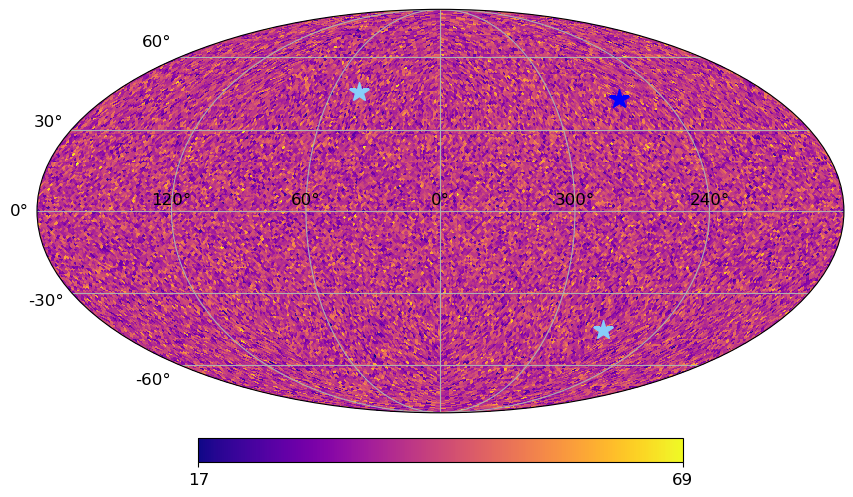

In [2]:
NSIDE = 64  
NPIX = hp.nside2npix(NSIDE)  
N_bar = 40
D = 0.007
Q = 0.014
dipole_theta = np.radians(48)
dipole_phi = -np.radians(96)

d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.pi/4, np.pi/4]
q_vector_2 = [np.pi*3/4, -np.pi/2]

m, lambda_array = dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector, q_vector_1, q_vector_2)

dipole_quad_plotting(m, d_vector, q_vector_1, q_vector_2)

# First, I am just checking that the uniform sampling works correctly. 

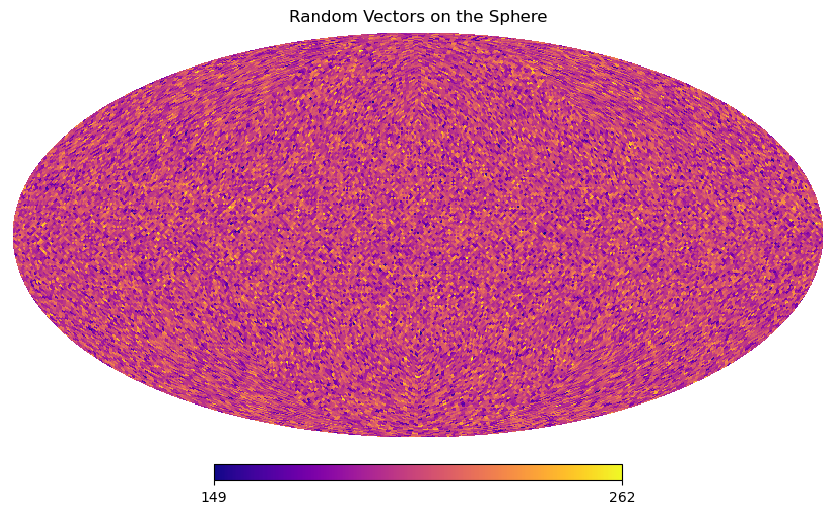

In [3]:
def draw_vectors(n):
    """Draw n random vectors on the sphere."""
    c = np.random.uniform(0,1,n)
    theta = np.arccos(1 - 2 * c)
    phi = np.random.uniform(0, 2 * np.pi, n)

    vectors = np.array([theta, phi]).T
    return vectors

NISDE= 64
NPIX= hp.nside2npix(NISDE)
quad_vectors = draw_vectors(10000000)
# Mark the selected directions in the map
m = np.full(NPIX, 0)

pixels = hp.ang2pix(NSIDE, quad_vectors[:, 0], quad_vectors[:, 1])
for pix in pixels:
    m[pix] += 1

hp.mollview(m, cmap='plasma', title="Random Vectors on the Sphere")
plt.show()


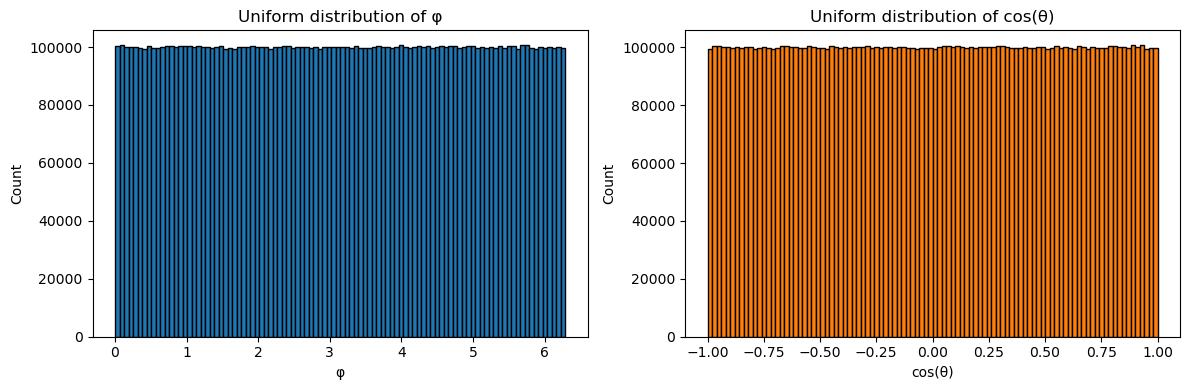

In [4]:
theta, phi = quad_vectors[:, 0], quad_vectors[:, 1]

# Histogram of phi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(phi, bins=100, color='C0', edgecolor='k')
plt.xlabel('φ')
plt.ylabel('Count')
plt.title('Uniform distribution of φ')

# Histogram of cos(theta)
plt.subplot(1, 2, 2)
plt.hist(np.cos(theta), bins=100, color='C1', edgecolor='k')
plt.xlabel('cos(θ)')
plt.ylabel('Count')
plt.title('Uniform distribution of cos(θ)')
plt.tight_layout()
plt.show()

In [5]:
def dipole_quad_plotting(m, d_vector=None, q_vector_1=None, q_vector_2=None, title=None, unit=None, cmap='plasma'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap);
    # adjusting the angles to be in the range [-pi, pi] for plotting
    if q_vector_1[1] > np.pi:
        q_vector_1[1] = q_vector_1[1]- 2*np.pi
    if q_vector_2[1] > np.pi:
        q_vector_2[1] = q_vector_2[1]- 2*np.pi  
    newprojplot(theta=d_vector[0], phi=d_vector[1], marker="*", color="b", markersize=15);
    newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="lightskyblue", markersize=15);
    newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="lightskyblue", markersize=15);
    plt.tight_layout()

    return

# Great, now i can sample 2 vectors, and use these as the quad vectors for a fixed dipole. 

In [96]:
def draw_vectors(n):
    """Draw n random vectors on the sphere."""
    c = np.random.uniform(0,1,n)
    theta = np.arccos(1 - 2 * c)
    phi = np.random.uniform(0, 2 * np.pi, n)

    vectors = np.array([theta, phi]).T
    return vectors


In [175]:
def draw_vectors(n):
    """Draw n random vectors on the sphere."""
    c = np.random.uniform(0,1,n)
    theta = np.arccos(1 - 2 * c)
    phi = np.random.uniform(0, 2 * np.pi, n)

    vectors = np.array([theta, phi]).T
    return vectors

NSIDE = 64  
NPIX = hp.nside2npix(NSIDE)  
N_bars = [1,5,10,20,40,60,80,100]
D = 0.007
Q = 0.014
dipole_theta = np.radians(48)
dipole_phi = -np.radians(96)
d_vector = [dipole_theta, dipole_phi]

np.random.seed(42)  # For reproducibility

for N_bar in N_bars:
    for i in range(1000):
        vectors = draw_vectors(2)
        q_vector_1 = vectors[0]
        q_vector_2 = vectors[1]

        m, lambda_array = dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector, q_vector_1, q_vector_2)

        metadata = {
                'Nbar': N_bar,
                'D': D,
                'Q': Q,
                'NSIDE': NSIDE,
                'NPIX': NPIX,
                'dipole_vector': d_vector,
                'quad_vector_1': q_vector_1,
                'quad_vector_2': q_vector_2
            }
        

        data_to_save = {
            'm': m,
            'metadata': metadata
        }

        np.save(f"../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Datasets/Raw_Files/Nbar_{N_bar}/skymap_data_Nbar_{N_bar}_{i}.npy", data_to_save)

    # dipole_quad_plotting(m, d_vector, q_vector_1, q_vector_2)

In [8]:
# read in the saved data
def read_skymap_data(file_path):
    data = np.load(file_path, allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    return m, metadata

df = pd.DataFrame(columns=['quad_vector_1', 'quad_vector_2'])
# Example usage
N_bar=40
alignment_list = []
for i in range(1000):
    m, metadata = read_skymap_data(f"../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_{i}.npy")
    d_vector = metadata['dipole_vector']
    q_vector_1 = metadata['quad_vector_1']
    q_vector_2 = metadata['quad_vector_2']

    # angle between d_vector and q_vector_1
    d_vector_xyz = hp.ang2vec(d_vector[0], d_vector[1])
    q_vector_1_xyz = hp.ang2vec(q_vector_1[0], q_vector_1[1])
    q_vector_2_xyz = hp.ang2vec(q_vector_2[0], q_vector_2[1])

    dp1 = np.dot(d_vector_xyz, q_vector_1_xyz)
    dp2 = np.dot(d_vector_xyz, q_vector_2_xyz)
    dp3 = np.dot(q_vector_1_xyz, q_vector_2_xyz)

    alignment = 1/3 * (dp1 + dp2 + dp3)
    alignment_list.append(alignment)

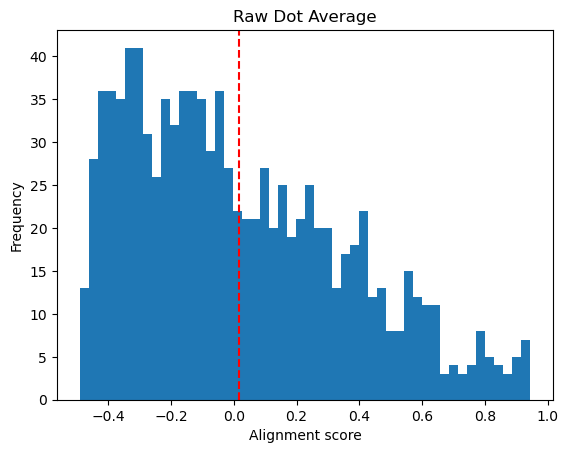

In [9]:
plt.hist(alignment_list, bins=50)
plt.title("Raw Dot Average")
plt.axvline(np.mean(alignment_list), color='red', linestyle='--', label='Mean')
plt.xlabel('Alignment score')
plt.ylabel('Frequency')
plt.show()

In [10]:
df = pd.DataFrame(columns=['quad_vector_1', 'quad_vector_2'])
# Example usage
N_bar=40
alignment_list = []
dipole_theta = np.radians(48)
dipole_phi = -np.radians(96)
d_vector = [dipole_theta, dipole_phi]
for i in range(100000):
    vectors = draw_vectors(3)
    q_vector_1 = vectors[0]
    q_vector_2 = vectors[1]
    d_vector = vectors[2]

    # angle between d_vector and q_vector_1
    d_vector_xyz = hp.ang2vec(d_vector[0], d_vector[1])
    q_vector_1_xyz = hp.ang2vec(q_vector_1[0], q_vector_1[1])
    q_vector_2_xyz = hp.ang2vec(q_vector_2[0], q_vector_2[1])

    angle_1 = np.dot(d_vector_xyz, q_vector_1_xyz)
    angle_2 = np.dot(d_vector_xyz, q_vector_2_xyz)
    angle_3 = np.dot(q_vector_1_xyz, q_vector_2_xyz)

    alignment = 1/3 * (angle_1 + angle_2 + angle_3)
    alignment_list.append(alignment)



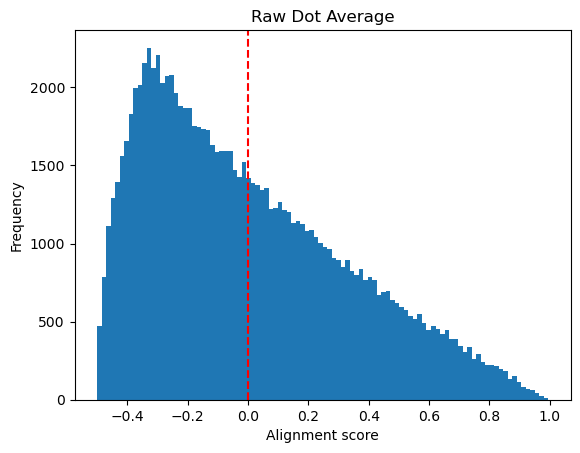

In [11]:
plt.hist(alignment_list, bins=100)
plt.title("Raw Dot Average")
plt.axvline(np.mean(alignment_list), color='red', linestyle='--', label='Mean')
plt.xlabel('Alignment score')
plt.ylabel('Frequency')
plt.show()


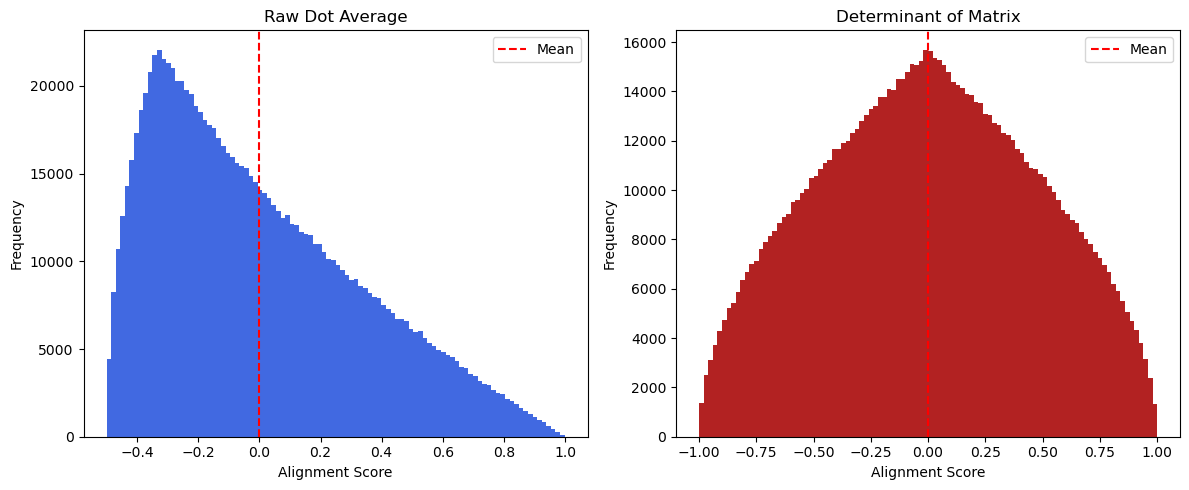

In [ ]:
# Compute alignment metrics
def compute_metrics(v1, v2, v3):
    dp12 = np.dot(v1, v2)
    dp13 = np.dot(v1, v3)
    dp23 = np.dot(v2, v3)

    raw_alignment = (dp12 + dp13 + dp23) / 3
    determinant = np.linalg.det(np.vstack([v1, v2, v3]))
    return raw_alignment, determinant

# Simulate
N = 1000000
dp_list = []
det_list = []

for _ in range(N):
    vectors = draw_vectors(3)
    v1 = hp.ang2vec(vectors[0][0], vectors[0][1])
    v2 = hp.ang2vec(vectors[1][0], vectors[1][1])
    v3 = hp.ang2vec(vectors[2][0], vectors[2][1])

    raw, det = compute_metrics(v1, v2, v3)
    dp_list.append(raw)
    det_list.append(det)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(dp_list/N, bins=100, density=False, alpha=1, color='royalblue')
axs[0].set_title("Dot Product Average")
axs[0].axvline(np.mean(dp_list), color='red', linestyle='--', label='Mean')
axs[0].set_xlabel('Alignment Score', fontsize=16)
axs[0].set_ylabel('Probability', fontsize=16)
axs[0].legend()

axs[1].hist(det_list/N, bins=100, density=False, alpha=1, color='firebrick')
axs[1].set_title("Determinant of Matrix")
axs[1].axvline(np.mean(det_list), color='red', linestyle='--', label='Mean')
axs[1].set_xlabel('Alignment Score', fontsize=16)
axs[1].set_ylabel('Probability', fontsize=16)
axs[1].legend()

plt.tight_layout()
# plt.savefig("../Figures/alignment_metrics.png", dpi=300)
plt.show()

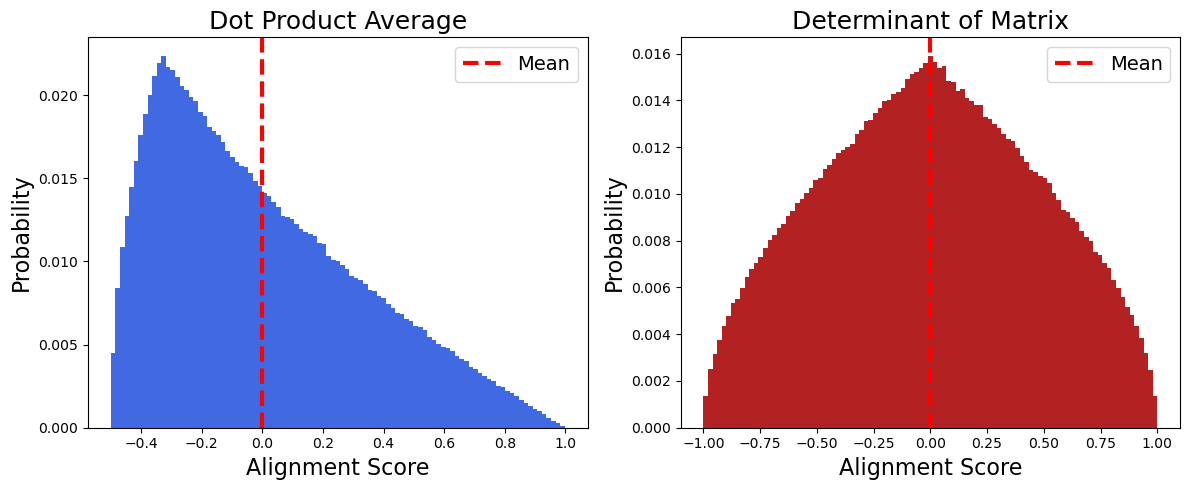

In [109]:
# Plot
# convert dp_list to probabilities
bin_edges = np.linspace(min(dp_list), max(dp_list), 100)
bin_width = bin_edges[1] - bin_edges[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(dp_list, bins=bin_edges, weights=np.ones_like(dp_list)/len(dp_list), alpha=1, color='royalblue')
axs[0].set_title("Dot Product Average", fontsize=18)
axs[0].axvline(np.mean(dp_list), color='red', linestyle='--', label='Mean', linewidth=3)
axs[0].set_xlabel('Alignment Score', fontsize=16)
axs[0].set_ylabel('Probability', fontsize=16)
axs[0].legend(fontsize=14)

bin_edges = np.linspace(min(det_list), max(det_list), 100)
bin_width = bin_edges[1] - bin_edges[0]


axs[1].hist(det_list, bins=bin_edges, weights=np.ones_like(det_list)/len(det_list), alpha=1, color='firebrick')
axs[1].set_title("Determinant of Matrix", fontsize=18)
axs[1].axvline(np.mean(det_list), color='red', linestyle='--', label='Mean', linewidth=3)
axs[1].set_xlabel('Alignment Score', fontsize=16)
axs[1].set_ylabel('Probability', fontsize=16)
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.savefig("../Thesis_images/alignment_metrics.pdf", dpi=300)
plt.show()


### The determinant method is calcuating the signed volume of the parallelepiped formed by the three vectors, which is a measure of how aligned they are. A value close to zero indicates that the vectors are nearly coplanar, while a larger absolute value indicates that they are more aligned in three-dimensional space. I dont like this method, because it cannot distinguish between 3 vectors that are coplanar (aligned along a plane in 3D but not parallel) and vectors that are all parallel. For example, 3 vectors spaced by 120 degrees each in a plane witll give 0, but so will 3 vectors pointing in the same direction. This will be a problem, because vectors pointing in the same direction will clearly have a different NS fit than those spaced by 120 degrees, even if it is in a plane

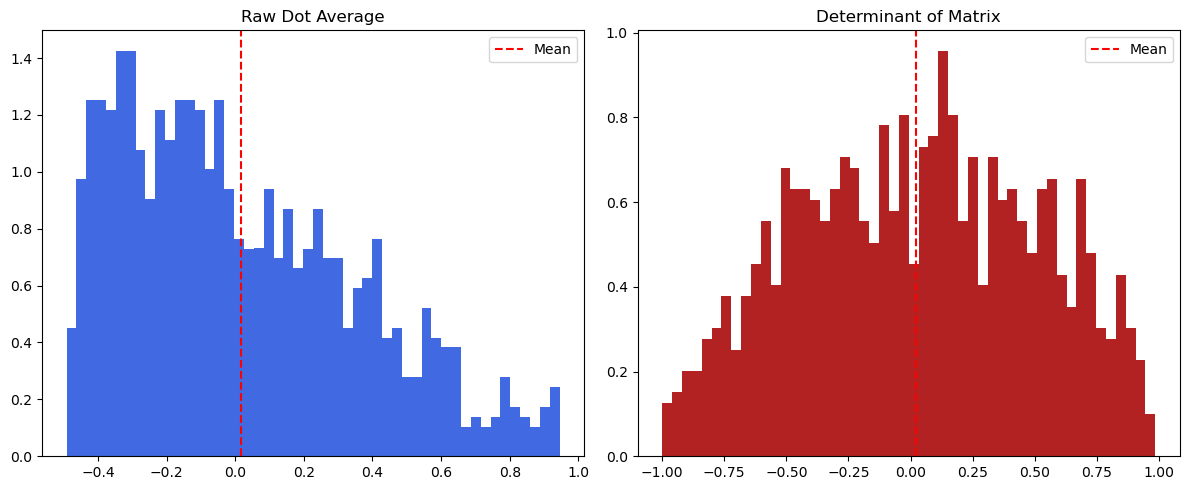

In [13]:
# For the actual 1000 simulations:

# Compute alignment metrics
def compute_metrics(v1, v2, v3):
    dp12 = np.dot(v1, v2)
    dp13 = np.dot(v1, v3)
    dp23 = np.dot(v2, v3)

    raw_alignment = (dp12 + dp13 + dp23) / 3
    determinant = np.linalg.det(np.vstack([v1, v2, v3]))
    return raw_alignment, determinant

# Simulate
N = 1000
dp_list = []
det_list = []

for i in range(N):
    m, metadata = read_skymap_data(f"../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_{i}.npy")
    d_vector = metadata['dipole_vector']
    q_vector_1 = metadata['quad_vector_1']
    q_vector_2 = metadata['quad_vector_2']

    # angle between d_vector and q_vector_1
    d_vector_xyz = hp.ang2vec(d_vector[0], d_vector[1])
    q_vector_1_xyz = hp.ang2vec(q_vector_1[0], q_vector_1[1])
    q_vector_2_xyz = hp.ang2vec(q_vector_2[0], q_vector_2[1])


    raw, det = compute_metrics(d_vector_xyz, q_vector_1_xyz, q_vector_2_xyz)
    dp_list.append(raw)
    det_list.append(det)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(dp_list, bins=50, density=True, alpha=1, color='royalblue')
axs[0].set_title("Raw Dot Average")
axs[0].axvline(np.mean(dp_list), color='red', linestyle='--', label='Mean')
axs[0].legend()

axs[1].hist(det_list, bins=50, density=True, alpha=1, color='firebrick')
axs[1].set_title("Determinant of Matrix")
axs[1].axvline(np.mean(det_list), color='red', linestyle='--', label='Mean')
axs[1].legend()

plt.tight_layout()
plt.show()

# Cool. Now I have sent these 1000 files to the cluster to run, fitting all 4 models. I have set the dipole parameters to be fixed around a small region around the true values (mimicking a delta function). Below, I am just reading in a few tests I ran locally to look at the fits.

In [14]:
file_path = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_model/dipole_Nbar_40_0/chains/equal_weighted_post.txt"
df=pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, names=['Nbar', 'D', 'l', 'b'])
df

Nbar         D         l         b
0     40.022664  0.007086  4.614908  0.841473
1     39.993369  0.007081  4.603697  0.838920
2     39.970035  0.006961  4.615732  0.844517
3     39.985036  0.007059  4.607228  0.845655
4     39.969604  0.007066  4.602381  0.830120
...         ...       ...       ...       ...
5140  39.947950  0.007056  4.614963  0.843237
5141  40.017129  0.007045  4.613109  0.845654
5142  40.021658  0.006901  4.613561  0.841527
5143  39.992436  0.006921  4.609471  0.843602
5144  39.975564  0.006911  4.614203  0.846211

[5145 rows x 4 columns]

In [4]:
def process_vector_component(l, b, nside, smooth_sigma):
        # start = time.time()
        pixels = hp.ang2pix(nside, b, l, nest=False)
        healpix_map = np.bincount(pixels, minlength=hp.nside2npix(nside)).astype(np.float64)
        healpix_map /= healpix_map.sum()
        smoothed_map = hp.sphtfunc.smoothing(healpix_map, sigma=smooth_sigma)
        smoothed_map[smoothed_map < 0] = 0
        smoothed_map /= smoothed_map.sum()
        # end = time.time()
        # print(f"Processing time for l, b: {end - start:.2f} seconds")
        return smoothed_map
        

def get_projection_and_contours(hmap, contour_levels=[0.5, 1, 1.5, 2]):
        # start = time.time()
        X, Y, proj_map = hp.projview(hmap, return_only_data=True, xsize=100, cbar=False)
        P_xy = proj_map / proj_map.sum()
        t_contours, P_levels, P_integral = compute_2D_contours(P_xy, contour_levels)
        # end = time.time()
        # print(f"Projection and contour computation time: {end - start:.2f} seconds")
        return X, Y, P_xy, t_contours

In [ ]:
pathname = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/"
for i in range(1000):
    file_path = pathname + f"dipole_quadrupole_model/dipole_quadrupole_Nbar_40_{i}/chains/equal_weighted_post.txt"

    df=pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, names=['Nbar', 'D','Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2'])
    
    # First load the data and metadata
    data = np.load(pathname+f'Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_{i}.npy',
                    allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    NSIDE = metadata['NSIDE']
    NPIX = metadata['NPIX']
    dipole_vector = metadata['dipole_vector']
    q_vector_1 = metadata['quad_vector_1']
    q_vector_2 = metadata['quad_vector_2']
    
    # dipole_quad_plotting(m, d_vector=d_vector, q_vector_1=q_vector_1, q_vector_2=q_vector_2, cmap='plasma')
    # plt.savefig(pathname+f'Datasets/Skymaps/Unsmoothed/skymap_Nbar_40_{i}.png', dpi=300)
    # plt.close()
    
    # smooth_map = compute_smooth_map(m, angle_scale=1)

    # dipole_quad_plotting(smooth_map, d_vector=d_vector, q_vector_1=q_vector_1, q_vector_2=q_vector_2, cmap='plasma')
    # plt.savefig(pathname+f'Datasets/Skymaps/Smoothed/smoothed_skymap_Nbar_40_{i}.png', dpi=300)
    # plt.close()
    
    #Corner Plot
    corner.corner(df.values, 
                            labels=[r'$\bar N$', 'D', 'Q', r'$\ell$', r'$b$', r'$\ell_1$', r'$b_1$', r'$\ell_2$', r'$b_2$'],
                            truths=[40, 0.007, 0.014, 2*np.pi + dipole_vector[1], dipole_vector[0], q_vector_1[1], q_vector_1[0], q_vector_2[1], q_vector_2[0]],
                            truth_color='r')
    plt.savefig(pathname+f'dipole_quadrupole_model/Figures/Cornerplots/corner_Nbar_40_{i}.png', dpi=300)
    # plt.show()
    plt.close()
    l, b, l1, b1, l2, b2 = df['l'].values, df['b'].values, df['l1'].values, df['b1'].values, df['l2'].values, df['b2'].values

    NSIDE=64
    dipole_theta = dipole_vector[0]
    dipole_phi = dipole_vector[1]

    # Create maps for each vector
    smooth_sigma = 0.1
    smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
    smooth_map1 = process_vector_component(l1, b1, NSIDE, smooth_sigma)
    smooth_map2 = process_vector_component(l2, b2, NSIDE, smooth_sigma)

    X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)
    X1, Y1, P_xy1, t_contours1 = get_projection_and_contours(smooth_map1)
    X2, Y2, P_xy2, t_contours2 = get_projection_and_contours(smooth_map2)
    alphas = [0.3,0.5,0.7,0.9]
    c, c1, c2 = 'gray', 'orange', 'darkcyan'

    #plot
    empty_map = np.full(hp.nside2npix(64), np.nan)
    hp.projview(empty_map, cmap="Blues", graticule=True, graticule_labels=True, min=0, max=1, cbar=False)   
    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=20, zorder=5)
    # Fixing the range of longitudes for plotting, annoying!!
    if q_vector_1[1] > np.pi:
        q_vector_1[1] = q_vector_1[1]- 2*np.pi
    if q_vector_2[1] > np.pi:
        q_vector_2[1] = q_vector_2[1]- 2*np.pi  

    newprojplot(theta= q_vector_1[0], phi=q_vector_1[1], marker="*", color="crimson", markersize=20, zorder=5)
    newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="crimson", markersize=20, zorder=5)

    # plt.contourf(X, Y, P_xy, levels=[t_contours[-1], P_xy.max()], colors=[c], alpha=alphas[-1])
    # plt.contourf(X1, Y1, P_xy1, levels=[t_contours1[-1], P_xy1.max()], colors=[c1], alpha=alphas[-1])
    # plt.contourf(X2, Y2, P_xy2, levels=[t_contours2[-1], P_xy2.max()], colors=[c2], alpha=alphas[-1]) 
    
    # # Fill the other contours
    # for i in range(len(t_contours) - 1):
    #         plt.contourf(X, Y, P_xy, levels=[t_contours[i], t_contours[i+1]], colors=[c], alpha=alphas[i])
    #         plt.contourf(X1, Y1, P_xy1, levels=[t_contours1[i], t_contours1[i+1]], colors=[c1], alpha=alphas[i])
    #         plt.contourf(X2, Y2, P_xy2, levels=[t_contours2[i], t_contours2[i+1]], colors=[c2], alpha=alphas[i])

    # Plot the contour lines to show boundaries
    plt.contour(X, Y, P_xy, levels=t_contours, colors=c, linewidths=2.5)
    plt.contour(X1, Y1, P_xy1, levels=t_contours1, colors=c1, linewidths=2.5)
    plt.contour(X2, Y2, P_xy2, levels=t_contours2, colors=c2, linewidths=2.5)
    
    plt.tight_layout()
    plt.savefig(pathname+f'dipole_quadrupole_model/Figures/Contours/contours_Nbar_40_{i}.png', dpi=300)
    # plt.show()
    plt.close()
    # break


4.599253580133889 1.3171660285628795 3.761482191925223 2.6938544755015843


In [11]:
# Calculating the Bayes factor
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole'
folders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

dataframe = pd.DataFrame(columns=['model', 'index', 'evidence'])

for folder in folders:
    folder_path = os.path.join(pathname, folder)
    
    # Only walk the immediate subdirectories of folder_path
    for root, subdirs, _ in os.walk(folder_path):
        for subfolder in subdirs:
            # remove subfolder that ends in times
            if subfolder.endswith('times'):
                continue
            if subfolder.endswith('Figures'):
                continue

            file_path = os.path.join(root, subfolder, 'chains/run.txt') # this is the path to the UN run folder

            with open(file_path, 'r') as f:
                splits = subfolder.split('_')
                index = int(splits[-1])
                # print(splits)
                if len(splits) == 5:
                    model = 'dipole_quadrupole'
                else:
                    model = splits[0]
                df = pd.read_csv(file_path, delim_whitespace=True, comment='#')
                evidence = df['logz'].iloc[-1]

                # add the evidence to a dataframe
                new_row = pd.DataFrame([{'model': model, 'index': index, 'evidence': evidence}])
                dataframe = pd.concat([dataframe, new_row], ignore_index=True)
                # print(f"Evidence for {subfolder}: {evidence}")
                # break
            

        break  # Prevent descending into deeper levels

            

    

In [12]:
dataframe

model index       evidence
0              monopole   368 -160295.556077
1              monopole    92 -160280.560947
2              monopole    66 -160112.121821
3              monopole   501 -160063.419071
4              monopole   165 -160162.606208
...                 ...   ...            ...
2667  dipole_quadrupole   239 -160106.261943
2668  dipole_quadrupole    23 -160298.750589
2669  dipole_quadrupole   450 -160622.098184
2670  dipole_quadrupole   662 -160515.593992
2671  dipole_quadrupole   206 -160154.031687

[2672 rows x 3 columns]

In [22]:
monopole_model = dataframe[dataframe['model'] == 'monopole']
dipole_model = dataframe[dataframe['model'] == 'dipole']
quadrupole_model = dataframe[dataframe['model'] == 'quadrupole']
dipole_quadrupole_model = dataframe[dataframe['model'] == 'dipole_quadrupole']

monopole_model = monopole_model.sort_values(by=['index']).reset_index(drop=True)
dipole_model = dipole_model.sort_values(by=['index']).reset_index(drop=True)
quadrupole_model = quadrupole_model.sort_values(by=['index']).reset_index(drop=True)
dipole_quadrupole_model = dipole_quadrupole_model.sort_values(by=['index']).reset_index(drop=True)

In [23]:
bayes_factors = pd.DataFrame(columns=['Comparison', 'index', 'bayes_factor'])

S_3 = dipole_quadrupole_model['evidence'].values
S_2 = quadrupole_model['evidence'].values
S_1 = dipole_model['evidence'].values
S_0 = monopole_model['evidence'].values

index = dipole_quadrupole_model['index'].values
B_32 = S_3 - S_2
B_31 = S_3 - S_1
B_30 = S_3 - S_0

rows = []

for i in range(len(S_3)):
    rows.append({'Comparison': 'B_32', 'index': index[i], 'bayes_factor': B_32[i]})
    rows.append({'Comparison': 'B_31', 'index': index[i], 'bayes_factor': B_31[i]})
    rows.append({'Comparison': 'B_30', 'index': index[i], 'bayes_factor': B_30[i]})

# Append all at once
bayes_factors = pd.concat([bayes_factors, pd.DataFrame(rows)], ignore_index=True)

In [9]:
bayes_factors

Comparison index  bayes_factor
0          B_32     0     12.769347
1          B_31     0      9.101738
2          B_30     0     21.637780
3          B_32     1     15.836638
4          B_31     1      6.723988
...         ...   ...           ...
1999       B_31   666     16.117164
2000       B_30   666     27.671061
2001       B_32   667      9.319843
2002       B_31   667      3.616680
2003       B_30   667     12.462639

[2004 rows x 3 columns]

In [110]:
bayes_factors.to_csv('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/bayes_factors.csv', index=False)

In [10]:
B_30_df = bayes_factors[bayes_factors['Comparison'] == 'B_30']
B_31_df = bayes_factors[bayes_factors['Comparison'] == 'B_31']
B_32_df = bayes_factors[bayes_factors['Comparison'] == 'B_32']

# Calculate the alignment score 

In [16]:
def compute_metrics(v1, v2, v3):
    dp12 = np.dot(v1, v2)
    dp13 = np.dot(v1, v3)
    dp23 = np.dot(v2, v3)

    raw_alignment = (dp12 + dp13 + dp23) / 3
    determinant = np.linalg.det(np.vstack([v1, v2, v3]))
    return raw_alignment, determinant

pathname = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/"
alignment_dataframe = pd.DataFrame(columns=['index', 'raw_alignment', 'determinant'])

for i in range(668):
    file_path = pathname + f"dipole_quadrupole_model/dipole_quadrupole_Nbar_40_{i}/chains/equal_weighted_post.txt"

    df=pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, names=['Nbar', 'D','Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2'])
    
    # First load the data and metadata
    data = np.load(pathname+f'Datasets/Raw_Files/Nbar_{40}/skymap_data_Nbar_{N_bar}_{i}.npy',
                    allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    NSIDE = metadata['NSIDE']
    NPIX = metadata['NPIX']
    dipole_vector = metadata['dipole_vector']
    q_vector_1 = metadata['quad_vector_1']
    q_vector_2 = metadata['quad_vector_2']

    raw_alignment, determinant = compute_metrics(
        hp.ang2vec(dipole_vector[0], dipole_vector[1]),
        hp.ang2vec(q_vector_1[0], q_vector_1[1]),
        hp.ang2vec(q_vector_2[0], q_vector_2[1]))

    new_row = pd.DataFrame([{
        'index': i,
        'raw_alignment': raw_alignment,
        'determinant': determinant
    }])
    alignment_dataframe = pd.concat([alignment_dataframe, new_row], ignore_index=True)


In [12]:
B_30_df = pd.merge(B_30_df, alignment_dataframe, on='index', how='left')
B_31_df = pd.merge(B_31_df, alignment_dataframe, on='index', how='left')
B_32_df = pd.merge(B_32_df, alignment_dataframe, on='index', how='left')

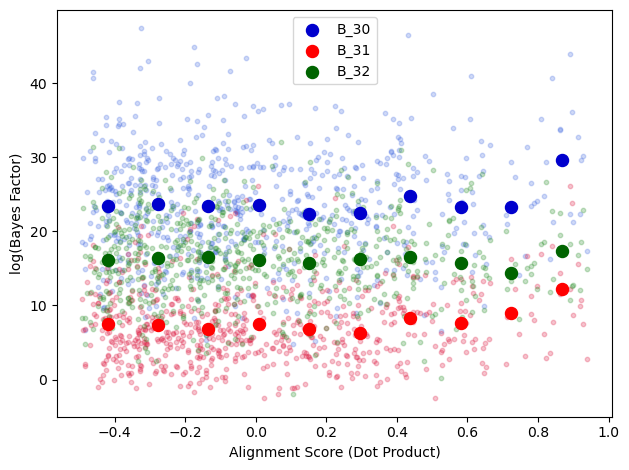

In [14]:
# Define 10 bins for raw_alignment
bins = np.linspace(alignment_dataframe['raw_alignment'].min(), alignment_dataframe['raw_alignment'].max(), 11)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def compute_binned_means(df, bins):
    bin_means = []
    for i in range(len(bins) - 1):
        bin_data = df[(df['raw_alignment'] >= bins[i]) & (df['raw_alignment'] < bins[i+1])]
        mean_value = bin_data['bayes_factor'].mean()
        bin_means.append(mean_value)
    return bin_means

b30_means = compute_binned_means(B_30_df, bins)
b31_means = compute_binned_means(B_31_df, bins)
b32_means = compute_binned_means(B_32_df, bins)

plt.scatter(B_30_df['raw_alignment'], B_30_df['bayes_factor'], s=10, alpha=0.25, color='royalblue')
plt.scatter(B_31_df['raw_alignment'], B_31_df['bayes_factor'], s=10, alpha=0.25, color='crimson')
plt.scatter(B_32_df['raw_alignment'], B_32_df['bayes_factor'], s=10, alpha=0.25, color='forestgreen')

plt.scatter(bin_centers, b30_means, marker='o', s=75, color='mediumblue', label='B_30')
plt.scatter(bin_centers, b31_means, marker='o', s=75, color='red', label='B_31')
plt.scatter(bin_centers, b32_means, marker='o', s=75, color='darkgreen', label='B_32')


plt.xlabel('Alignment Score (Dot Product)')
plt.ylabel('log(Bayes Factor)')
plt.legend()
plt.tight_layout()
# plt.savefig('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/binned_bayes_factors.png', dpi=300)
plt.show()

In [216]:
# I'm going to save this figure with the targeted file highlighted
for i in range(len(B_30_df)):
    plt.figure(figsize=(4, 4))
    plt.scatter(B_30_df['raw_alignment'], B_30_df['bayes_factor'], s=10, alpha=0.25, color='royalblue')
    plt.scatter(B_31_df['raw_alignment'], B_31_df['bayes_factor'], s=10, alpha=0.25, color='crimson')
    plt.scatter(B_32_df['raw_alignment'], B_32_df['bayes_factor'], s=10, alpha=0.25, color='forestgreen')
    plt.xlabel('Alignment Score (Dot Product)')
    plt.ylabel('log(Bayes Factor)')

    # now plot the ith row of the dataframe
    plt.scatter(B_30_df['raw_alignment'].iloc[i], B_30_df['bayes_factor'].iloc[i], label='B_30', marker='*', s=200, alpha=1, color='mediumblue')
    plt.scatter(B_31_df['raw_alignment'].iloc[i], B_31_df['bayes_factor'].iloc[i], label='B_31', marker='*', s=200, alpha=1, color='red')
    plt.scatter(B_32_df['raw_alignment'].iloc[i], B_32_df['bayes_factor'].iloc[i], label='B_32', marker='*', s=200, alpha=1, color='darkgreen')
    plt.legend()
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.savefig(f"../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/Bayes_Factors/bayes_factors_Nbar_40_{i}.png", dpi=300)
    plt.close()

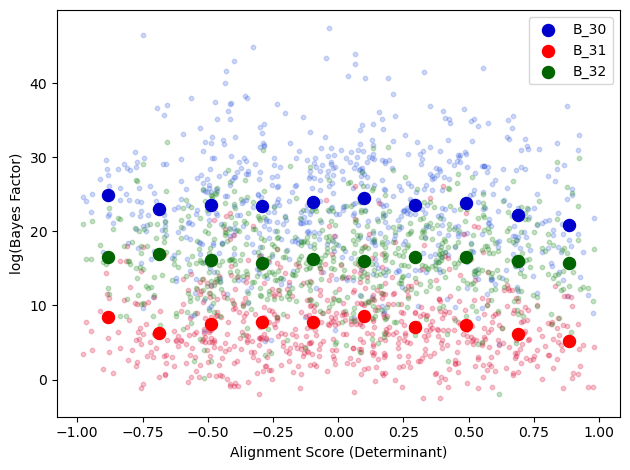

In [15]:
# Define 10 bins for determinant
bins = np.linspace(alignment_dataframe['determinant'].min(), alignment_dataframe['determinant'].max(), 11)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def compute_binned_means(df, bins):
    bin_means = []
    for i in range(len(bins) - 1):
        bin_data = df[(df['determinant'] >= bins[i]) & (df['determinant'] < bins[i+1])]
        mean_value = bin_data['bayes_factor'].mean()
        bin_means.append(mean_value)
    return bin_means

b30_means = compute_binned_means(B_30_df, bins)
b31_means = compute_binned_means(B_31_df, bins)
b32_means = compute_binned_means(B_32_df, bins)

plt.scatter(B_30_df['determinant'], B_30_df['bayes_factor'], s=10, alpha=0.25, color='royalblue')
plt.scatter(B_31_df['determinant'], B_31_df['bayes_factor'], s=10, alpha=0.25, color='crimson')
plt.scatter(B_32_df['determinant'], B_32_df['bayes_factor'], s=10, alpha=0.25, color='forestgreen')

plt.scatter(bin_centers, b30_means, marker='o', s=75, color='mediumblue', label='B_30')
plt.scatter(bin_centers, b31_means, marker='o', s=75, color='red', label='B_31')
plt.scatter(bin_centers, b32_means, marker='o', s=75, color='darkgreen', label='B_32')

plt.xlabel('Alignment Score (Determinant)')
plt.ylabel('log(Bayes Factor)')
plt.legend()
plt.tight_layout()
# plt.savefig('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/binned_bayes_factors_determinant.png', dpi=300)
plt.show()

# Now lets look at the inferred dipole and quadrupole amplitudes, and how this varies with the alignment score

In [6]:
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole'
folders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

global_df = pd.DataFrame(columns=['model', 'index'])

for folder in folders:
    folder_path = os.path.join(pathname, folder)
    
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)

        # Only process directories that aren't 'times' or 'Figures'
        if not os.path.isdir(subfolder_path):
            continue
        if subfolder.endswith('times') or subfolder.endswith('Figures'):
            continue

        # Correct path to file
        file_path = os.path.join(subfolder_path, 'info', 'results.json')

        if not os.path.isfile(file_path):
            print(f"Missing: {file_path}")
            continue

        splits = subfolder.split('_')
        index = int(splits[-1])
        
        if len(splits) == 5:
            model = 'dipole_quadrupole'
        else:
            model = splits[0]

        # if model == 'monopole':
        #     columns = ['Nbar']
        # elif model == 'dipole':
        #     columns = ['Nbar', 'D']
        # elif model == 'quadrupole':
        #     columns = ['Nbar', 'Q']
        # elif model == 'dipole_quadrupole':
        #     columns = ['Nbar', 'D', 'Q']
        # else:
        #     raise ValueError(f"Unknown model: {model}")

        with open(file_path, 'r') as f:
            data = json.load(f)

        # Extract posterior values
        posterior = data['posterior']

        # Create a DataFrame with median, errlo, and errup
        df = pd.DataFrame({
            'param_name': data['paramnames'],
            'median': posterior['median'],
            'errlo': posterior['errlo'],
            'errup': posterior['errup']
        })

        df['model'] = model
        df['index'] = index

        # Append to global DataFrame
        global_df = pd.concat([global_df, df], ignore_index=True)
        
    # break

        # last_row = df.iloc[[-1]].copy().astype(float)
        # last_row['model'], last_row['index'] = model, index

        # global_df = pd.concat([global_df, last_row], ignore_index=True)

In [7]:
global_df['param_name'] = global_df['param_name'].replace({
    '$\\bar N$': 'Nbar',
    '$\\ell$': 'l',
    '$\\ell_1$': 'l1',
    '$\\ell_2$': 'l2',
    '$b$': 'b',
    '$b_1$': 'b1',
    '$b_2$': 'b2'
    ''
})
global_df = global_df.sort_values(by=['index']).reset_index(drop=True)
global_df

model index param_name    median     errlo     errup
0             quadrupole     0         b2  1.597860  0.972130  2.170338
1             quadrupole     0         b1  1.545822  1.022322  2.068335
2             quadrupole     0         l1  1.776028  0.936487  4.521106
3             quadrupole     0          Q  0.015110  0.012470  0.017951
4      dipole_quadrupole     0         b2  1.559262  0.946834  2.180778
...                  ...   ...        ...       ...       ...       ...
13355  dipole_quadrupole   667          b  0.837822  0.830827  0.844956
13356  dipole_quadrupole   667         l1  3.179390  0.766297  5.600586
13357  dipole_quadrupole   667         b1  1.484231  0.899646  2.152304
13358             dipole   667          D  0.006994  0.006928  0.007062
13359  dipole_quadrupole   667         l2  2.955906  0.607598  5.318445

[13360 rows x 6 columns]

In [8]:
melted = global_df.melt(
    id_vars=['model', 'index', 'param_name'],
    value_vars=['median', 'errlo', 'errup'],
    var_name='stat',
    value_name='value'
)

# Create a new column like 'D_median', 'D_errlo', ...
melted['param_stat'] = melted['param_name'] + '_' + melted['stat']

# Pivot so each param_stat becomes its own column
wide_df = melted.pivot_table(
    index=['model', 'index'],
    columns='param_stat',
    values='value'
).reset_index()

# Optional: sort columns for clarity
cols = ['model', 'index'] + sorted([col for col in wide_df.columns if col not in ['model', 'index']])
wide_df = wide_df[cols]

In [9]:
wide_df.sort_values(by=['model', 'index'], inplace=True)
wide_df

param_stat       model  index   D_errlo   D_errup  D_median  Nbar_errlo  \
0               dipole      0  0.006930  0.007065  0.006997   39.965711   
1               dipole      1  0.006929  0.007069  0.007001   39.975193   
2               dipole      2  0.006932  0.007067  0.007000   39.962549   
3               dipole      3  0.006931  0.007064  0.006996   39.939321   
4               dipole      4  0.006929  0.007065  0.006992   39.968843   
...                ...    ...       ...       ...       ...         ...   
2667        quadrupole    663       NaN       NaN       NaN   39.969148   
2668        quadrupole    664       NaN       NaN       NaN   39.939737   
2669        quadrupole    665       NaN       NaN       NaN   39.956270   
2670        quadrupole    666       NaN       NaN       NaN   39.956267   
2671        quadrupole    667       NaN       NaN       NaN   39.969358   

param_stat  Nbar_errup  Nbar_median   Q_errlo   Q_errup  ...  b_median  \
0            40.026307    39.997843       NaN       NaN  ...  0.837949   
1            40.029581    40.002407       NaN       NaN  ...  0.838619   
2            40.019370    39.990690       NaN       NaN  ...  0.837598   
3            39.999513    39.969846       NaN       NaN  ...  0.838323   
4            40.024275    39.997244       NaN       NaN  ...  0.838281   
...                ...          ...       ...       ...  ...       ...   
2667         40.024219    39.996372  0.006715  0.012472  ...       NaN   
2668         39.995911    39.968109  0.011174  0.016892  ...       NaN   
2669         40.013851    39.984049  0.011991  0.017885  ...       NaN   
2670         40.015402    39.985398  0.015238  0.020805  ...       NaN   
2671         40.023979    39.998359  0.008699  0.014632  ...       NaN   

param_stat  l1_errlo  l1_errup  l1_median  l2_errlo  l2_errup  l2_median  \
0                NaN       NaN        NaN       NaN       NaN        NaN   
1                NaN       NaN        NaN       NaN       NaN        NaN   
2                NaN       NaN        NaN       NaN       NaN        NaN   
3                NaN       NaN        NaN       NaN       NaN        NaN   
4                NaN       NaN        NaN       NaN       NaN        NaN   
...              ...       ...        ...       ...       ...        ...   
2667        0.863670  5.846153   3.159275  1.314904  5.997082   3.273520   
2668        1.136367  5.205347   2.984292  1.503612  5.190640   3.256116   
2669        1.164065  5.439910   4.028177  1.169898  5.429166   2.739782   
2670        0.394090  5.681181   3.101053  0.393188  5.653681   3.030628   
2671        0.700028  4.462948   3.318050  0.694905  5.869024   3.273361   

param_stat   l_errlo   l_errup  l_median  
0           4.600902  4.614259  4.607607  
1           4.601285  4.614405  4.607729  
2           4.600878  4.614861  4.607691  
3           4.600786  4.614495  4.607434  
4           4.600742  4.614645  4.607912  
...              ...       ...       ...  
2667             NaN       NaN       NaN  
2668             NaN       NaN       NaN  
2669             NaN       NaN       NaN  
2670             NaN       NaN       NaN  
2671             NaN       NaN       NaN  

[2672 rows x 29 columns]

In [17]:
merged_df = pd.merge(wide_df, dataframe, on=['index', 'model'], how='left')
merged_df = merged_df.sort_values(by=['model', 'index']).reset_index(drop=True)
merged_df = pd.merge(merged_df, alignment_dataframe, on='index', how='left')
merged_df
# filter = merged_df[merged_df['model'] == 'dipole_quadrupole']
# filter

model index   D_errlo   D_errup  D_median  Nbar_errlo  Nbar_errup  \
0         dipole     0  0.006930  0.007065  0.006997   39.965711   40.026307   
1         dipole     1  0.006929  0.007069  0.007001   39.975193   40.029581   
2         dipole     2  0.006932  0.007067  0.007000   39.962549   40.019370   
3         dipole     3  0.006931  0.007064  0.006996   39.939321   39.999513   
4         dipole     4  0.006929  0.007065  0.006992   39.968843   40.024275   
...          ...   ...       ...       ...       ...         ...         ...   
2667  quadrupole   663       NaN       NaN       NaN   39.969148   40.024219   
2668  quadrupole   664       NaN       NaN       NaN   39.939737   39.995911   
2669  quadrupole   665       NaN       NaN       NaN   39.956270   40.013851   
2670  quadrupole   666       NaN       NaN       NaN   39.956267   40.015402   
2671  quadrupole   667       NaN       NaN       NaN   39.969358   40.023979   

      Nbar_median   Q_errlo   Q_errup  ...  l1_median  l2_errlo  l2_errup  \
0       39.997843       NaN       NaN  ...        NaN       NaN       NaN   
1       40.002407       NaN       NaN  ...        NaN       NaN       NaN   
2       39.990690       NaN       NaN  ...        NaN       NaN       NaN   
3       39.969846       NaN       NaN  ...        NaN       NaN       NaN   
4       39.997244       NaN       NaN  ...        NaN       NaN       NaN   
...           ...       ...       ...  ...        ...       ...       ...   
2667    39.996372  0.006715  0.012472  ...   3.159275  1.314904  5.997082   
2668    39.968109  0.011174  0.016892  ...   2.984292  1.503612  5.190640   
2669    39.984049  0.011991  0.017885  ...   4.028177  1.169898  5.429166   
2670    39.985398  0.015238  0.020805  ...   3.101053  0.393188  5.653681   
2671    39.998359  0.008699  0.014632  ...   3.318050  0.694905  5.869024   

      l2_median   l_errlo   l_errup  l_median       evidence  raw_alignment  \
0           NaN  4.600902  4.614259  4.607607 -160307.546677      -0.230506   
1           NaN  4.601285  4.614405  4.607729 -160633.666734      -0.250949   
2           NaN  4.600878  4.614861  4.607691 -160331.288307      -0.010628   
3           NaN  4.600786  4.614495  4.607434 -160141.036939      -0.461547   
4           NaN  4.600742  4.614645  4.607912 -160339.651525       0.264487   
...         ...       ...       ...       ...            ...            ...   
2667   3.273520       NaN       NaN       NaN -160376.311107       0.101406   
2668   3.256116       NaN       NaN       NaN -160736.679806      -0.084155   
2669   2.739782       NaN       NaN       NaN -160467.534111       0.124493   
2670   3.030628       NaN       NaN       NaN -160350.198393      -0.043014   
2671   3.273361       NaN       NaN       NaN -160541.794248      -0.323729   

      determinant  
0       -0.831345  
1       -0.294492  
2        0.151632  
3       -0.370326  
4        0.380903  
...           ...  
2667    -0.000612  
2668     0.871161  
2669    -0.171691  
2670     0.950456  
2671     0.394871  

[2672 rows x 32 columns]

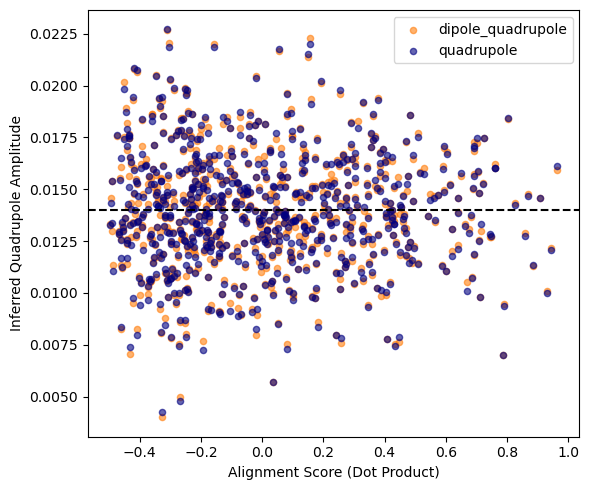

In [18]:
plot_df = merged_df[merged_df['model'].isin(['quadrupole', 'dipole_quadrupole'])].dropna(subset=['Q_median', 'raw_alignment'])

colors = {'quadrupole': 'navy', 'dipole_quadrupole': 'C1'}

plt.figure(figsize=(6, 5))
for model, group in plot_df.groupby('model'):
    plt.scatter(group['raw_alignment'], group['Q_median'], label=model, s=20, alpha=0.6, color=colors[model])

plt.axhline(0.014, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Alignment Score (Dot Product)')
plt.ylabel('Inferred Quadrupole Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

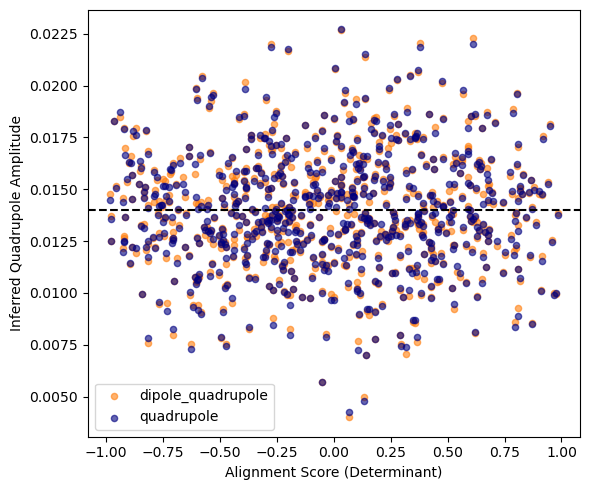

In [19]:
plot_df = merged_df[merged_df['model'].isin(['quadrupole', 'dipole_quadrupole'])].dropna(subset=['Q_median', 'determinant'])

colors = {'quadrupole': 'navy', 'dipole_quadrupole': 'C1'}

plt.figure(figsize=(6, 5))
for model, group in plot_df.groupby('model'):
    plt.scatter(group['determinant'], group['Q_median'], label=model, s=20, alpha=0.6, color=colors[model])

plt.axhline(0.014, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Alignment Score (Determinant)')
plt.ylabel('Inferred Quadrupole Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Adding the bayes factors to the merged dataframe

bf_pivot = bayes_factors.pivot_table(index='index', columns='Comparison', values='bayes_factor').reset_index()

final_df = pd.merge(merged_df, bf_pivot, on='index', how='left')
final_df.sort_values(by=['index'], inplace=True)
final_df

model index   D_errlo   D_errup  D_median  Nbar_errlo  \
0                dipole     0  0.006930  0.007065  0.006997   39.965711   
668   dipole_quadrupole     0  0.006925  0.007061  0.006981   39.968427   
2004         quadrupole     0       NaN       NaN       NaN   39.970175   
1336           monopole     0       NaN       NaN       NaN   39.968252   
669   dipole_quadrupole     1  0.006934  0.007070  0.006998   39.973964   
...                 ...   ...       ...       ...       ...         ...   
666              dipole   666  0.006933  0.007067  0.007002   39.955366   
1335  dipole_quadrupole   667  0.006930  0.007062  0.006991   39.970049   
667              dipole   667  0.006928  0.007062  0.006994   39.968615   
2003           monopole   667       NaN       NaN       NaN   39.968457   
2671         quadrupole   667       NaN       NaN       NaN   39.969358   

      Nbar_errup  Nbar_median   Q_errlo   Q_errup  ...  l2_median   l_errlo  \
0      40.026307    39.997843       NaN       NaN  ...        NaN  4.600902   
668    40.022738    39.995852  0.012606  0.017825  ...   1.689629  4.600870   
2004   40.024016    39.996952  0.012470  0.017951  ...   1.783106       NaN   
1336   40.024685    39.996278       NaN       NaN  ...        NaN       NaN   
669    40.027567    40.002150  0.010968  0.016083  ...   3.045122  4.600429   
...          ...          ...       ...       ...  ...        ...       ...   
666    40.011026    39.984235       NaN       NaN  ...        NaN  4.600631   
1335   40.028362    39.999633  0.009086  0.014776  ...   2.955906  4.601111   
667    40.027298    39.997946       NaN       NaN  ...        NaN  4.600841   
2003   40.024048    39.997778       NaN       NaN  ...        NaN       NaN   
2671   40.023979    39.998359  0.008699  0.014632  ...   3.273361       NaN   

       l_errup  l_median       evidence  raw_alignment  determinant  \
0     4.614259  4.607607 -160307.546677      -0.230506    -0.831345   
668   4.614606  4.607922 -160298.444939      -0.230506    -0.831345   
2004       NaN       NaN -160311.214286      -0.230506    -0.831345   
1336       NaN       NaN -160320.082719      -0.230506    -0.831345   
669   4.614436  4.607083 -160626.942746      -0.250949    -0.294492   
...        ...       ...            ...            ...          ...   
666   4.614585  4.607313 -160354.591919      -0.043014     0.950456   
1335  4.614500  4.607948 -160532.474405      -0.323729     0.394871   
667   4.614629  4.607616 -160536.091085      -0.323729     0.394871   
2003       NaN       NaN -160544.937044      -0.323729     0.394871   
2671       NaN       NaN -160541.794248      -0.323729     0.394871   

           B_30       B_31       B_32  
0     21.637780   9.101738  12.769347  
668   21.637780   9.101738  12.769347  
2004  21.637780   9.101738  12.769347  
1336  21.637780   9.101738  12.769347  
669   22.067412   6.723988  15.836638  
...         ...        ...        ...  
666   27.671061  16.117164  11.723638  
1335  12.462639   3.616680   9.319843  
667   12.462639   3.616680   9.319843  
2003  12.462639   3.616680   9.319843  
2671  12.462639   3.616680   9.319843  

[2672 rows x 35 columns]

In [25]:
mono_df = final_df[final_df['model'] == 'monopole']
mono_df = mono_df.dropna(axis=1, how='all')


dipole_df = final_df[final_df['model'] == 'dipole']
dipole_df = dipole_df.dropna(axis=1, how='all')


quad_df = final_df[final_df['model'] == 'quadrupole']
quad_df = quad_df.dropna(axis=1, how='all')

dp_df = final_df[final_df['model'] == 'dipole_quadrupole']
dp_df = dp_df.dropna(axis=1, how='all')

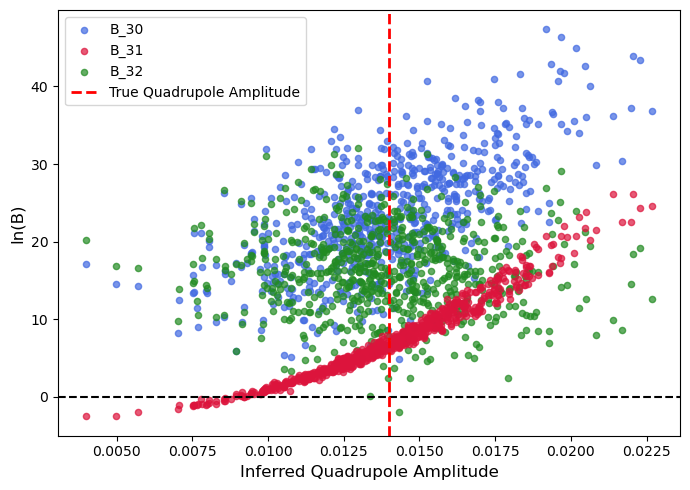

In [26]:
plt.figure(figsize=(7, 5))
plt.scatter(dp_df['Q_median'], dp_df['B_30'], label='B_30', s=20, alpha=0.7, color='royalblue', zorder=0)
plt.scatter(dp_df['Q_median'], dp_df['B_31'], label='B_31', s=20, alpha=0.7, color='crimson', zorder=2)
plt.scatter(dp_df['Q_median'], dp_df['B_32'], label='B_32', s=20, alpha=0.7, color='forestgreen', zorder=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.axvline(0.014, color='red', linestyle='--', linewidth=2, label='True Quadrupole Amplitude')
plt.legend()
plt.xlabel('Inferred Quadrupole Amplitude', fontsize=12)
plt.ylabel('ln(B)', fontsize=12)
plt.tight_layout()
plt.savefig('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/bayes_factors_vs_Q.png', dpi=300)
plt.show()


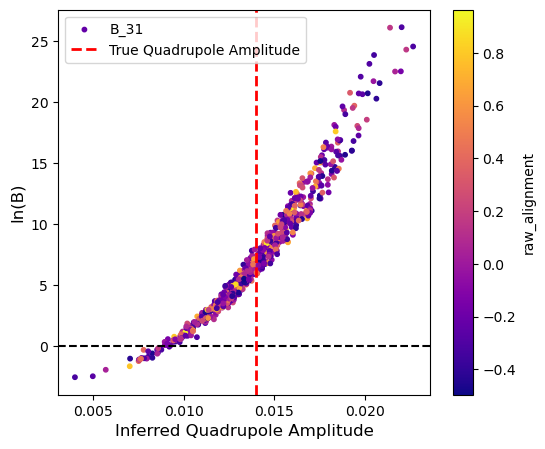

In [27]:
colour_scale = 'raw_alignment'
cmap = 'plasma'
plt.figure(figsize=(6, 5))
plt.scatter(dp_df['Q_median'], dp_df['B_31'], label='B_31', s=10, alpha=1, c=dp_df[colour_scale], cmap=cmap)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.axvline(0.014, color='red', linestyle='--', linewidth=2, label='True Quadrupole Amplitude')
plt.legend()
plt.xlabel('Inferred Quadrupole Amplitude', fontsize=12)
plt.ylabel('ln(B)', fontsize=12)
plt.colorbar(label=colour_scale)
plt.show()

# Code for subplots below

In [ ]:
# What do i want to know?
# 1. How does the alignment score relate to the Bayes factor?
# 2. How does the inferred quadrupole amplitude relate to the alignment score?
# 3. How does the inferred quadrupole amplitude relate to the Bayes factor?
# 4. How does the inferred quadrupole amplitude relate to the alignment score and Bayes factor?

In [ ]:
pathname = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/"
Q_samples = []
true_Q = 0.014 

for i in range(668):
    file_path = os.path.join(pathname, f"dipole_quadrupole_model/dipole_quadrupole_Nbar_40_{i}/chains/equal_weighted_post.txt")
    df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                    skiprows=1, names=['Nbar', 'D', 'Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2'])
    Q_data = df['Q'].values.reshape(-1, 1)
    
    plt.figure(figsize=(4,4))
    corner.corner(Q_data, labels=["$Q$"], show_titles=True,
                            title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
                            title_kwargs={"fontsize": 10},
                    color="k",  # color for median line and edges
                    hist_kwargs={"alpha": 0.9, "color": "royalblue", "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
                    smooth1d_kwargs={"color": "blue", "alpha": 0.6})

    plt.axvline(true_Q, color='red', linestyle='--', label='True Q', linewidth=1.5)

    plt.tight_layout()

    # Optionally save the figure to disk
    output_dir = os.path.join(pathname, "dipole_quadrupole_model/Figures/Q_corner_plots")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"Q_posterior_run_{i}.png"), dpi=300)
    
    plt.close()  # Prevent memory buildup
    

<Figure size 400x400 with 0 Axes>

In [220]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

skymap_path     = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Datasets/Skymaps/Smoothed/smoothed_skymap_Nbar_40_{}.png'
contour_path    = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/Contours/contours_Nbar_40_{}.png'
corner_path     = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/Q_corner_plots/Q_posterior_run_{}.png'
bayesfac_path   = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/Bayes_Factors/bayes_factors_Nbar_40_{}.png'

output_dir = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/Combined_Figures/'
os.makedirs(output_dir, exist_ok=True)

for i in range(668):  # 0 to 667 inclusive
    try:
        # Load the images
        images = [
            mpimg.imread(skymap_path.format(i)),
            mpimg.imread(contour_path.format(i)),
            mpimg.imread(corner_path.format(i)),
            mpimg.imread(bayesfac_path.format(i))
        ]

        # Create subplot with different column widths
        fig = plt.figure(figsize=(12, 10))
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

        axs = [
            fig.add_subplot(gs[0, 0]),
            fig.add_subplot(gs[1, 0]),
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 1])
        ]

        for ax, img in zip(axs, images):
            ax.imshow(img)
            ax.axis('off')

        plt.tight_layout()
        output_path = os.path.join(output_dir, f'combined_figure_{i}.png')
        plt.savefig(output_path, dpi=300)
        # plt.show()
        plt.close(fig)
        # break
    except FileNotFoundError as e:
        print(f"Skipping index {i} due to missing file: {e}")

In [ ]:
# import matplotlib.gridspec as gridspec

# true_Q = 0.014
# pathname = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/"

# for i in range(1000):
#     try:
#         # Load posterior data
#         file_path = os.path.join(pathname, f"dipole_quadrupole_model/dipole_quadrupole_Nbar_40_{i}/chains/equal_weighted_post.txt")
#         df = pd.read_csv(file_path, delim_whitespace=True, header=None,
#                          skiprows=1, names=['Nbar', 'D','Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2'])

#         # Load skymap and metadata
#         N_bar = 40
#         data = np.load(pathname + f'Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_{i}.npy',
#                        allow_pickle=True).item()
#         m = data['m']
#         metadata = data['metadata']
#         NSIDE = metadata['NSIDE']
#         dipole_vector = metadata['dipole_vector']
#         q_vector_1 = metadata['quad_vector_1']
#         q_vector_2 = metadata['quad_vector_2']

#         # Set up figure and 2x2 grid with wider left column
#         fig = plt.figure(figsize=(12, 8))
#         gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.3)

#         # === Top Left: Skymap ===
#         smooth_map = compute_smooth_map(m, angle_scale=1)

#         # Use mollview in subplot (1-indexed: sub=(rows, cols, index))
#         hp.mollview(smooth_map, cmap='plasma', title="", sub=(2, 2, 1))
#         hp.graticule(dpar=30, dmer=60)

#         # === Bottom Left: Contours ===
#         l, b = df['l'].values, df['b'].values
#         l1, b1 = df['l1'].values, df['b1'].values
#         l2, b2 = df['l2'].values, df['b2'].values

#         smooth_sigma = 0.1
#         NSIDE = 64
#         dipole_theta, dipole_phi = dipole_vector

#         smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
#         smooth_map1 = process_vector_component(l1, b1, NSIDE, smooth_sigma)
#         smooth_map2 = process_vector_component(l2, b2, NSIDE, smooth_sigma)

#         X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)
#         X1, Y1, P_xy1, t_contours1 = get_projection_and_contours(smooth_map1)
#         X2, Y2, P_xy2, t_contours2 = get_projection_and_contours(smooth_map2)

#         alphas = [0.3, 0.5, 0.7, 0.9]
#         c, c1, c2 = 'gray', 'orange', 'darkcyan'

#         empty_map = np.full(hp.nside2npix(NSIDE), np.nan)

#         # This will plot the mollweide projection in bottom-left subplot (3rd subplot in 2x2 grid)
#         hp.mollview(empty_map, cmap="Blues", cbar=False, title="", sub=(2, 2, 3))
#         hp.graticule(dpar=30, dmer=60)

#         if q_vector_1[1] > np.pi:
#             q_vector_1[1] -= 2 * np.pi
#         if q_vector_2[1] > np.pi:
#             q_vector_2[1] -= 2 * np.pi

#         plt.contour(X, Y, P_xy, levels=t_contours, colors='gray', linewidths=2.5)
#         plt.contour(X1, Y1, P_xy1, levels=t_contours1, colors='orange', linewidths=2.5)
#         plt.contour(X2, Y2, P_xy2, levels=t_contours2, colors='darkcyan', linewidths=2.5)

#         newprojplot(theta=dipole_vector[0], phi=dipole_vector[1], marker="*", color="k", markersize=20, zorder=5)
#         newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="crimson", markersize=20, zorder=5)
#         newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="crimson", markersize=20, zorder=5)
#         # === Top Right: Q Posterior Histogram ===
#         ax_post = plt.subplot(gs[0, 1])
#         Q_data = df['Q'].values

#         # Plot filled histogram manually
#         n, bins, patches = ax_post.hist(Q_data, bins=40, density=True, histtype="stepfilled",
#                                         alpha=0.8, color="royalblue", edgecolor="k", linewidth=1.5)

#         # Add vertical line for true Q
#         ax_post.axvline(true_Q, color='red', linestyle='--', linewidth=1.5, label='True $Q$')

#         # Add median line
#         q_median = np.median(Q_data)
#         ax_post.axvline(q_median, color='k', linestyle='--', linewidth=1.2, label='Median')

#         # Labels and formatting
#         ax_post.set_xlabel(r"$Q$", fontsize=12)
#         ax_post.set_ylabel("")
#         ax_post.set_yticks([])
#         ax_post.tick_params(labelsize=10)
#         ax_post.legend(fontsize=9)
#         ax_post.set_title("Posterior of $Q$", fontsize=12)

#         # === Bottom Right: Placeholder ===
#         ax_blank = plt.subplot(gs[1, 1])
#         ax_blank.axis("off")
#         ax_blank.set_title("Bayes Factor (TBD)")

#         plt.show()

#         break  # Remove this to process all files

#     except Exception as e:
#         print(f"[{i}] Error: {e}")

# Now looking at the same figures / trends but for different Nbar values 

In [4]:
# Calculating the Bayes factor
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Cluster_Files'
folders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

dataframe = pd.DataFrame(columns=['model', 'index', 'N_bar', 'evidence'])

for folder in folders:
    folder_path = os.path.join(pathname, folder)
    
    # Only walk the immediate subdirectories of folder_path
    for root, subdirs, _ in os.walk(folder_path):
        for subfolder in subdirs:
            # remove subfolder that ends in times
            if subfolder.endswith('times'):
                continue
            if subfolder.endswith('Figures'):
                continue

            file_path = os.path.join(root, subfolder, 'info/results.json') # this is the path to the UN run folder

            with open(file_path, 'r') as f:
                splits = subfolder.split('_')
                index = int(splits[-1])
                N_bar = int(splits[-2])  
                if len(splits) == 5:
                    model = 'dipole_quadrupole'
                else:
                    model = splits[0]
                with open(file_path, 'r') as f:
                    data = json.load(f)
                evidence = data['logz']

                # add the evidence to a dataframe
                new_row = pd.DataFrame([{'model': model, 'index': index, 'N_bar': N_bar, 'evidence': evidence}])
                dataframe = pd.concat([dataframe, new_row], ignore_index=True)
                # print(f"Evidence for {subfolder}: {evidence}")
                # break
            

        break  # Prevent descending into deeper levels

            


In [5]:
dataframe

model index N_bar       evidence
0               monopole   368    40 -160295.555987
1               monopole   497    60 -170057.004056
2               monopole   476    10 -125883.350633
3               monopole   394    80 -177324.161240
4               monopole    92    40 -160280.560862
...                  ...   ...   ...            ...
15995  dipole_quadrupole   322   100 -183027.864020
15996  dipole_quadrupole    32     5 -108220.074450
15997  dipole_quadrupole   458    80 -177201.487488
15998  dipole_quadrupole   188    10 -126125.770472
15999  dipole_quadrupole   169    60 -170351.441199

[16000 rows x 4 columns]

In [8]:
monopole_model = dataframe[dataframe['model'] == 'monopole']
dipole_model = dataframe[dataframe['model'] == 'dipole']
quadrupole_model = dataframe[dataframe['model'] == 'quadrupole']
dipole_quadrupole_model = dataframe[dataframe['model'] == 'dipole_quadrupole']

monopole_model = monopole_model.sort_values(by=['N_bar', 'index']).reset_index(drop=True)
dipole_model = dipole_model.sort_values(by=['N_bar', 'index']).reset_index(drop=True)
quadrupole_model = quadrupole_model.sort_values(by=['N_bar', 'index']).reset_index(drop=True)
dipole_quadrupole_model = dipole_quadrupole_model.sort_values(by=['N_bar', 'index']).reset_index(drop=True)

In [26]:
bayes_factors = pd.DataFrame(columns=['Comparison', 'N_bar', 'index', 'bayes_factor'])

S_3 = dipole_quadrupole_model['evidence'].values
S_2 = quadrupole_model['evidence'].values
S_1 = dipole_model['evidence'].values
S_0 = monopole_model['evidence'].values

index = dipole_quadrupole_model['index'].values
B_32 = S_3 - S_2
B_31 = S_3 - S_1
B_30 = S_3 - S_0

df_B32 = pd.DataFrame({
    'Comparison': 'B_32',
    'N_bar': dipole_quadrupole_model['N_bar'],
    'index': dipole_quadrupole_model['index'],
    'bayes_factor': B_32
})

df_B31 = pd.DataFrame({
    'Comparison': 'B_31',
    'N_bar': dipole_quadrupole_model['N_bar'],
    'index': dipole_quadrupole_model['index'],
    'bayes_factor': B_31
})

df_B30 = pd.DataFrame({
    'Comparison': 'B_30',
    'N_bar': dipole_quadrupole_model['N_bar'],
    'index': dipole_quadrupole_model['index'],
    'bayes_factor': B_30
})

bayes_factors = pd.concat([df_B32, df_B31, df_B30], ignore_index=True)



In [27]:
bayes_factors

Comparison N_bar index  bayes_factor
0           B_32     1     0     -1.355634
1           B_32     1     1     -0.809997
2           B_32     1     2     -0.385508
3           B_32     1     3      0.652677
4           B_32     1     4     -1.321111
...          ...   ...   ...           ...
11995       B_30   100   495     69.375089
11996       B_30   100   496     68.111861
11997       B_30   100   497     78.975097
11998       B_30   100   498     61.970557
11999       B_30   100   499     67.638355

[12000 rows x 4 columns]

In [52]:
B_30_df = bayes_factors[bayes_factors['Comparison'] == 'B_30']
B_31_df = bayes_factors[bayes_factors['Comparison'] == 'B_31']
B_32_df = bayes_factors[bayes_factors['Comparison'] == 'B_32']

In [30]:
def compute_metrics(v1, v2, v3):
    dp12 = np.dot(v1, v2)
    dp13 = np.dot(v1, v3)
    dp23 = np.dot(v2, v3)

    raw_alignment = (dp12 + dp13 + dp23) / 3
    determinant = np.linalg.det(np.vstack([v1, v2, v3]))
    return raw_alignment, determinant

pathname = "../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/"
alignment_dataframe = pd.DataFrame(columns=['N_bar', 'index', 'raw_alignment', 'determinant'])
N_bars = [1,5,10,20,40,60,80,100]

for N_bar in N_bars:
    for i in range(499):
        # file_path = pathname + f"dipole_quadrupole_model/dipole_quadrupole_Nbar_40_{i}/chains/equal_weighted_post.txt"

        # df=pd.read_csv(file_path, delim_whitespace=True, header=None, skiprows=1, names=['Nbar', 'D','Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2'])
        
        # First load the data and metadata
        data = np.load(pathname+f'Datasets/Raw_Files/Nbar_{N_bar}/skymap_data_Nbar_{N_bar}_{i}.npy',
                        allow_pickle=True).item()
        m = data['m']
        metadata = data['metadata']
        NSIDE = metadata['NSIDE']
        NPIX = metadata['NPIX']
        dipole_vector = metadata['dipole_vector']
        q_vector_1 = metadata['quad_vector_1']
        q_vector_2 = metadata['quad_vector_2']

        raw_alignment, determinant = compute_metrics(
            hp.ang2vec(dipole_vector[0], dipole_vector[1]),
            hp.ang2vec(q_vector_1[0], q_vector_1[1]),
            hp.ang2vec(q_vector_2[0], q_vector_2[1]))

        new_row = pd.DataFrame([{
            'N_bar': N_bar,
            'index': i,
            'raw_alignment': raw_alignment,
            'determinant': determinant
        }])
        
        alignment_dataframe = pd.concat([alignment_dataframe, new_row], ignore_index=True)


In [54]:
# merge on index and N_bar
B_30_df = pd.merge(B_30_df, alignment_dataframe, on=['index', 'N_bar'], how='left')
B_31_df = pd.merge(B_31_df, alignment_dataframe, on=['index', 'N_bar'], how='left')
B_32_df = pd.merge(B_32_df, alignment_dataframe, on=['index', 'N_bar'], how='left')


In [56]:
B_31_df

Comparison N_bar index  bayes_factor  raw_alignment  determinant
0          B_31     1     0     -1.143912       0.183851    -0.142491
1          B_31     1     1     -2.243833      -0.352391    -0.663590
2          B_31     1     2     -1.167516       0.468234     0.375910
3          B_31     1     3     -0.897639       0.305600     0.405868
4          B_31     1     4     -1.325201      -0.180852     0.163903
...         ...   ...   ...           ...            ...          ...
3995       B_31   100   495     33.720643      -0.172565    -0.116038
3996       B_31   100   496     28.974279      -0.197819    -0.588638
3997       B_31   100   497     34.556075       0.291478     0.466030
3998       B_31   100   498     21.518870       0.171181    -0.791388
3999       B_31   100   499     24.487022            NaN          NaN

[4000 rows x 6 columns]

In [ ]:
df = pd.concat([B_30_df, B_31_df, B_32_df], ignore_index=True)
df.to_csv('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/merged_bayes_factors.csv', index=False)

# Start here, read in the saved Bayes factors

In [3]:
df = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/merged_bayes_factors.csv')
df

Comparison  N_bar  index  bayes_factor  raw_alignment  determinant
0           B_30      1      0     -2.537724       0.183851    -0.142491
1           B_30      1      1     -2.501642      -0.352391    -0.663590
2           B_30      1      2     -0.822214       0.468234     0.375910
3           B_30      1      3     -0.410981       0.305600     0.405868
4           B_30      1      4     -2.483619      -0.180852     0.163903
...          ...    ...    ...           ...            ...          ...
11995       B_32    100    495     37.799036      -0.172565    -0.116038
11996       B_32    100    496     40.562292      -0.197819    -0.588638
11997       B_32    100    497     46.650959       0.291478     0.466030
11998       B_32    100    498     41.169574       0.171181    -0.791388
11999       B_32    100    499     43.022253            NaN          NaN

[12000 rows x 6 columns]

In [ ]:
B_30_df = df[df['Comparison'] == 'B_30']
B_31_df = df[df['Comparison'] == 'B_31']
B_32_df = df[df['Comparison'] == 'B_32']

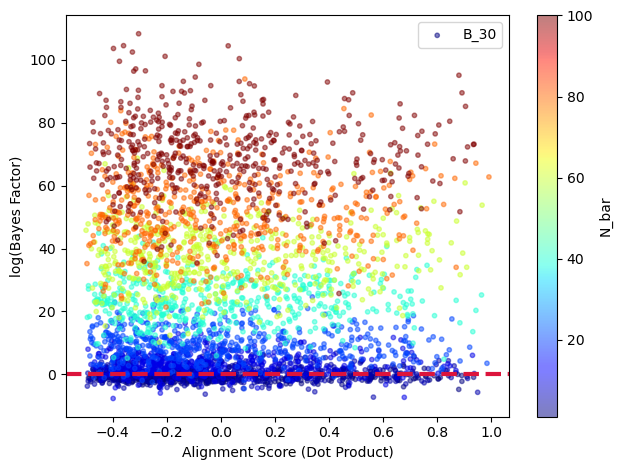

In [ ]:
plt.scatter(B_30_df['raw_alignment'], B_30_df['bayes_factor'], s=10, alpha=0.5, c=B_30_df['N_bar'], cmap='jet', label='B_30')
plt.xlabel('Alignment Score (Dot Product)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()

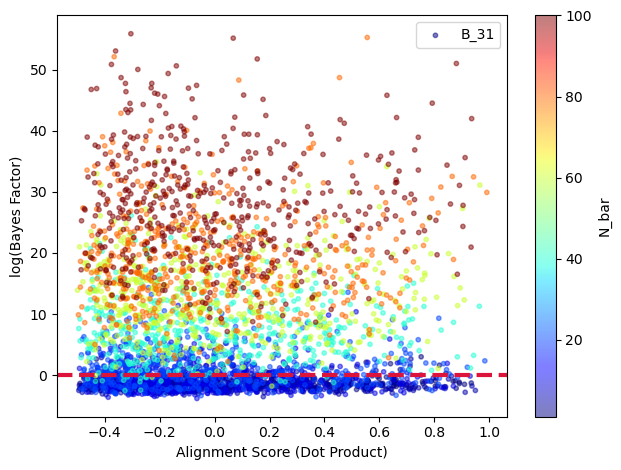

In [85]:
plt.scatter(B_31_df['raw_alignment'], B_31_df['bayes_factor'], s=10, alpha=0.5, c=B_31_df['N_bar'], cmap='jet', label='B_31')
plt.xlabel('Alignment Score (Dot Product)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()


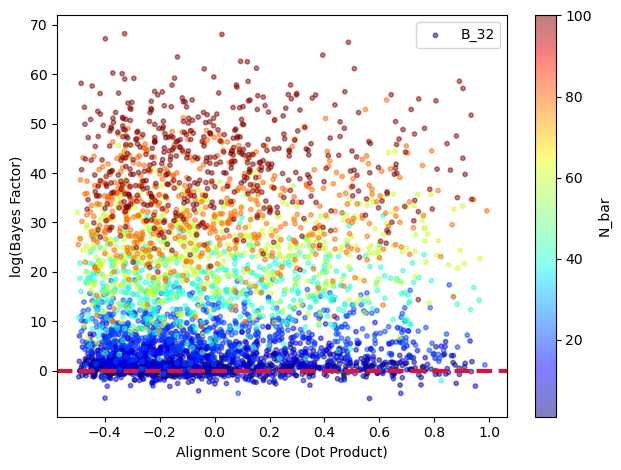

In [84]:
plt.scatter(B_32_df['raw_alignment'], B_32_df['bayes_factor'], s=10, alpha=0.5, c=B_32_df['N_bar'], cmap='jet', label='B_32')
plt.xlabel('Alignment Score (Dot Product)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()

# Determinat instead of raw alignment 

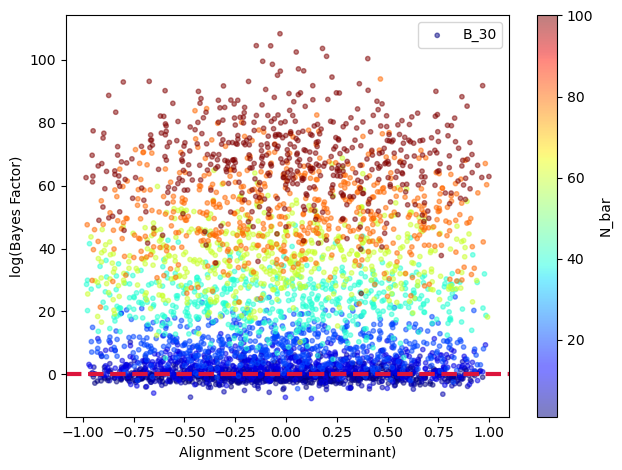

In [203]:
plt.scatter(B_30_df['determinant'], B_30_df['bayes_factor'], s=10, alpha=0.5, c=B_30_df['N_bar'], cmap='jet', label='B_30')
plt.xlabel('Alignment Score (Determinant)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()

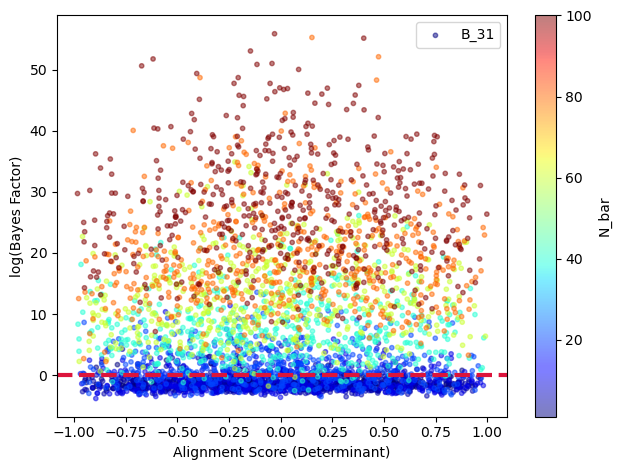

In [443]:
plt.scatter(B_31_df['determinant'], B_31_df['bayes_factor'], s=10, alpha=0.5, c=B_31_df['N_bar'], cmap='jet', label='B_31')
plt.xlabel('Alignment Score (Determinant)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()

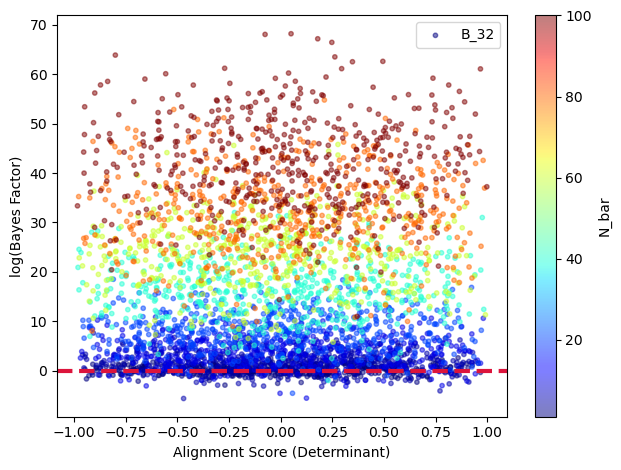

In [91]:
plt.scatter(B_32_df['determinant'], B_32_df['bayes_factor'], s=10, alpha=0.5, c=B_32_df['N_bar'], cmap='jet', label='B_32')
plt.xlabel('Alignment Score (Determinant)')
plt.ylabel('log(Bayes Factor)')
plt.colorbar(label='N_bar')
plt.axhline(0, color='crimson', linestyle='--', linewidth=3)
plt.legend()
plt.tight_layout()

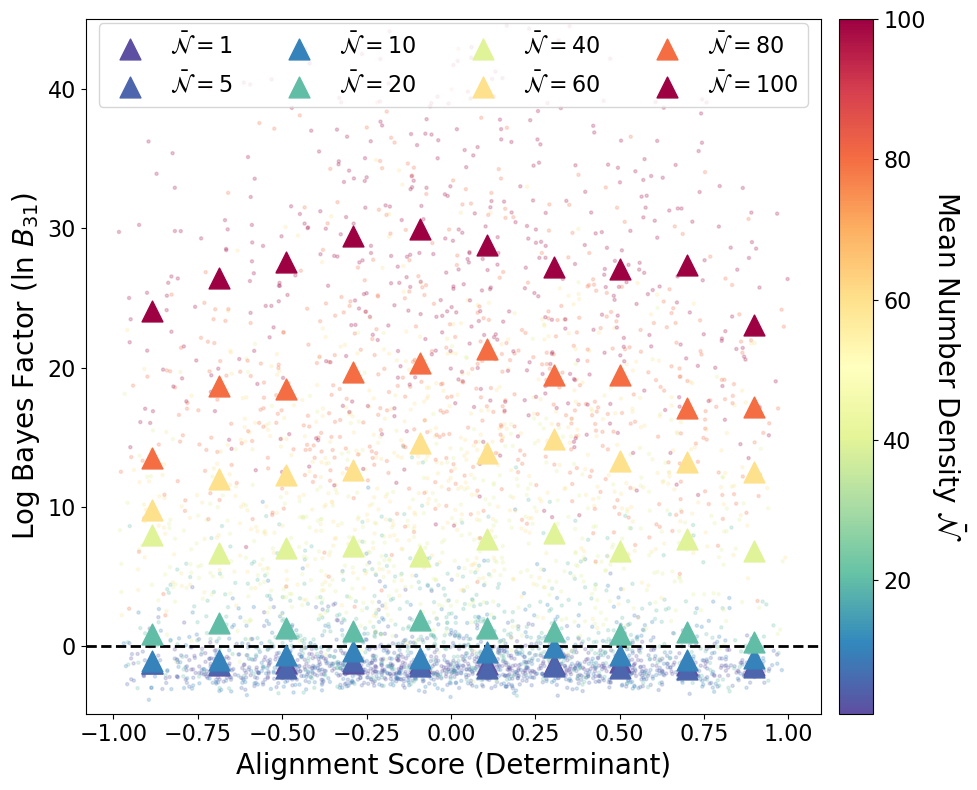

In [113]:
from matplotlib.colors import Normalize
from matplotlib import cm

def truncate_colormap(cmap, minval=0.05, maxval=1.0, n=256):
    new_cmap = cm.colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap = truncate_colormap(plt.cm.Spectral_r, minval=0.0, maxval=1.0)
norm = Normalize(vmin=B_30_df['N_bar'].min(), vmax=B_30_df['N_bar'].max())

metric = 'determinant' 
# metric = 'raw_alignment'  
bins = np.linspace(B_31_df[metric].min(), B_31_df[metric].max(), 11)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
N_bars = [1,5,10,20,40,60,80,100]

dfs = {
    # 'B_30_df': B_30_df,
    'B_31_df': B_31_df,
    # 'B_32_df': B_32_df
}

for name, df in dfs.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, N_bar in enumerate(N_bars):
        df_N = df[df['N_bar'] == N_bar].copy()

        # Bin the data
        df_N['bin'] = pd.cut(df_N[metric], bins=bins, labels=False, include_lowest=True)
        binned = df_N.groupby('bin')['bayes_factor'].mean()
        binned_err = df_N.groupby('bin')['bayes_factor'].std()

        # Mask bins with no data
        valid = ~binned.isna()

        # Plot with markers
        ax.scatter(bin_centers[valid], binned[valid], marker='^', s=225,
                    label=rf'$\bar{{\mathcal{{N}}}} = {N_bar}$',
                    color=cmap(norm(N_bar)), zorder=2)

    # Raw scatter
    sc = ax.scatter(df[metric], df['bayes_factor'], s=5, alpha=0.2,
                c=df['N_bar'], cmap=cmap, norm=norm, zorder=0)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label(r'Mean Number Density $\bar{\mathcal{N}}$', rotation=270, labelpad=30, fontsize=20)
    cbar.ax.tick_params(labelsize=16)


    plt.xlabel('Alignment Score (Determinant)', fontsize=20)

    # Extract 30/31/32 from the name like 'B_30_df'
    bf_ij = name.split('_')[1]
    plt.ylabel(r'Log Bayes Factor (ln $B_{' + bf_ij + '}$)', fontsize=20)

    plt.axhline(0, color='k', linestyle='--', linewidth=2, zorder=1)
    # plt.axhline(5, color='crimson', linestyle='--', linewidth=2, zorder=1)
    plt.ylim(B_31_df['bayes_factor'].min() - 1, 45)
    # increase tick fontsize
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
        
    # Add legend
    #make the legend centered
    plt.legend(fontsize=16, ncol=len(N_bars) // 2, loc='upper center', bbox_to_anchor=(0.5, 1.01))
    plt.tight_layout()
    # plt.savefig(f'../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/binned_bayes_factors_{metric}_{name}.png', dpi=300)
    # plt.savefig('../Thesis_images/binned_bayes_factors_Spectral.pdf', dpi=300)
    plt.show()

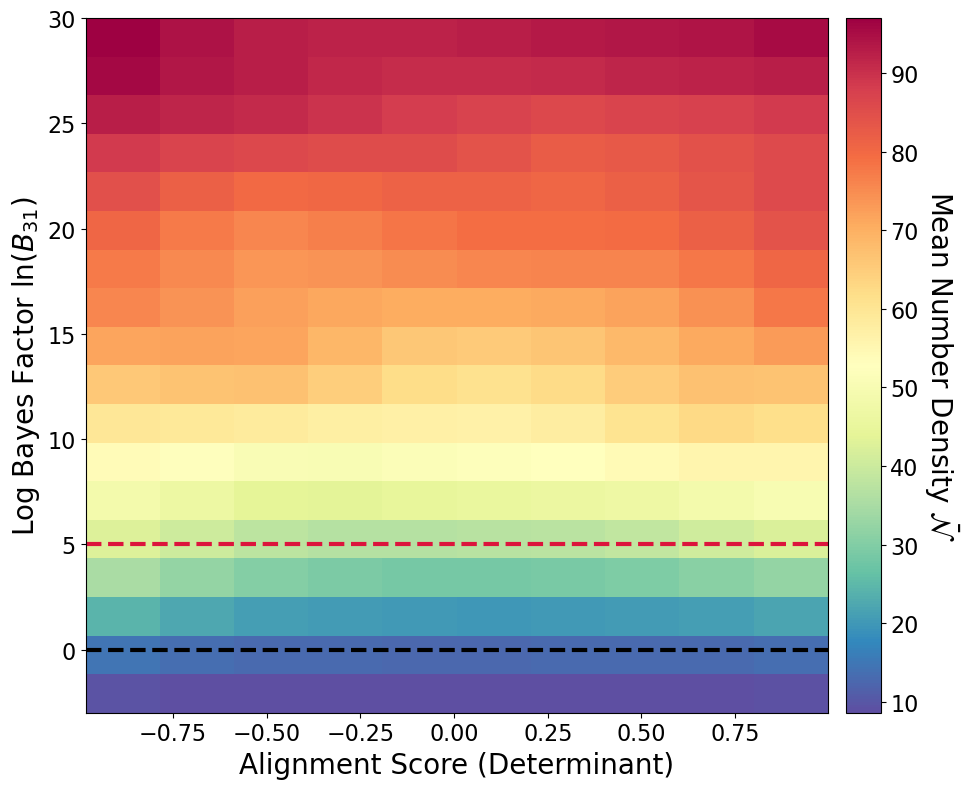

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
n_bins_x = 10
n_bins_y = 18

# Define bin edges for x and y
x_edges = np.linspace(B_31_df['determinant'].min(), B_31_df['determinant'].max(), n_bins_x + 1)
y_edges = np.linspace(-3, 30, n_bins_y + 1)

# Initialize array to hold average N_bar per 2D bin
Z = np.full((n_bins_y, n_bins_x), np.nan)  # shape: (y_bins, x_bins)

# Extract data arrays
x = B_31_df['determinant'].values
y = B_31_df['bayes_factor'].values
c = B_31_df['N_bar'].values

# Digitize points to find bin indices
x_bin_indices = np.digitize(x, x_edges) - 1  # subtract 1 to get zero-based indices
y_bin_indices = np.digitize(y, y_edges) - 1

# Filter out-of-range indices (can happen on right edge)
valid = (x_bin_indices >= 0) & (x_bin_indices < n_bins_x) & (y_bin_indices >= 0) & (y_bin_indices < n_bins_y)
x_bin_indices = x_bin_indices[valid]
y_bin_indices = y_bin_indices[valid]
c = c[valid]

# Create a 2D structure to collect values per bin for averaging
from collections import defaultdict
bin_values = defaultdict(list)
# Aggregate N_bar values in each bin
for xb, yb, val in zip(x_bin_indices, y_bin_indices, c):
    bin_values[(yb, xb)].append(val)
# Compute average N_bar per bin
for (yb, xb), values in bin_values.items():
    Z[yb, xb] = np.mean(values)

Z_smooth = gaussian_filter(Z, sigma=1)

# Create meshgrid for bin edges (for pcolormesh, edges needed)
X, Y = np.meshgrid(x_edges, y_edges)

# Plot heatmap
plt.figure(figsize=(10, 8))
pcm = plt.pcolormesh(X, Y, Z_smooth, shading='auto', cmap=cmap)
cbar = plt.colorbar(pcm, pad=0.02)
cbar.set_label(r'Mean Number Density $\bar{\mathcal{N}}$', rotation=270, labelpad=30, fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.xlabel('Alignment Score (Determinant)', fontsize=20)
plt.ylabel(r'Log Bayes Factor ln($B_{31}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0, color='k', linestyle='--', linewidth=3)
plt.axhline(5, color='crimson', linestyle='--', linewidth=3)
plt.tight_layout()

plt.savefig('../Thesis_images/heatmap_bayes_factors_Spectral.pdf', dpi=300)
plt.show()

In [512]:
for df in [B_30_df, B_31_df, B_32_df]:
    print(f'{df}')

     Comparison  N_bar  index  bayes_factor  raw_alignment  determinant
0          B_30      1      0     -2.537724       0.183851    -0.142491
1          B_30      1      1     -2.501642      -0.352391    -0.663590
2          B_30      1      2     -0.822214       0.468234     0.375910
3          B_30      1      3     -0.410981       0.305600     0.405868
4          B_30      1      4     -2.483619      -0.180852     0.163903
...         ...    ...    ...           ...            ...          ...
3995       B_30    100    495     69.375089      -0.172565    -0.116038
3996       B_30    100    496     68.111861      -0.197819    -0.588638
3997       B_30    100    497     78.975097       0.291478     0.466030
3998       B_30    100    498     61.970557       0.171181    -0.791388
3999       B_30    100    499     67.638355            NaN          NaN

[4000 rows x 6 columns]
     Comparison  N_bar  index  bayes_factor  raw_alignment  determinant
4000       B_31      1      0     -1.14

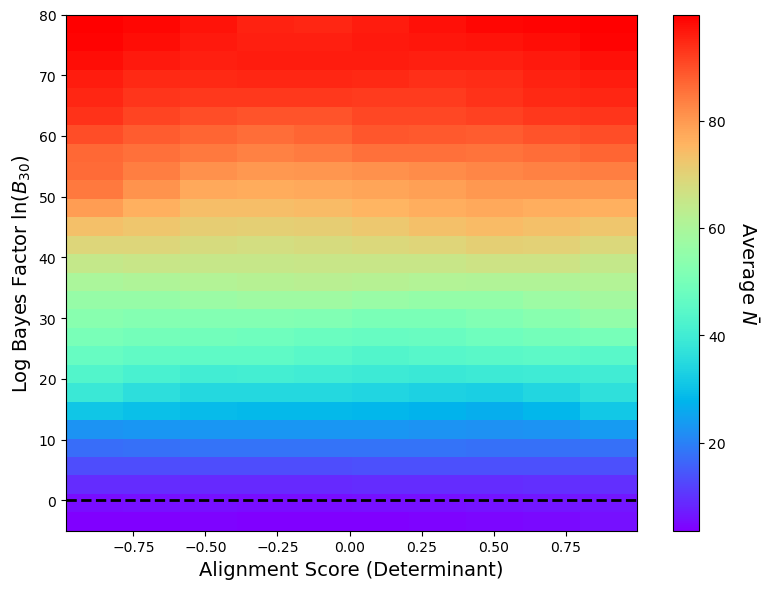

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Define number of bins
n_bins_x = 10
n_bins_y = 28

# Define bin edges for x and y
x_edges = np.linspace(B_30_df['determinant'].min(), B_30_df['determinant'].max(), n_bins_x + 1)
y_edges = np.linspace(-5, 80, n_bins_y + 1)

# Initialize array to hold average N_bar per 2D bin
Z = np.full((n_bins_y, n_bins_x), np.nan)  # shape: (y_bins, x_bins)

# Extract data arrays
x = B_30_df['determinant'].values
y = B_30_df['bayes_factor'].values
c = B_30_df['N_bar'].values

# Digitize points to find bin indices
x_bin_indices = np.digitize(x, x_edges) - 1  # subtract 1 to get zero-based indices
y_bin_indices = np.digitize(y, y_edges) - 1

# Filter out-of-range indices (can happen on right edge)
valid = (x_bin_indices >= 0) & (x_bin_indices < n_bins_x) & (y_bin_indices >= 0) & (y_bin_indices < n_bins_y)
x_bin_indices = x_bin_indices[valid]
y_bin_indices = y_bin_indices[valid]
c = c[valid]

# Create a 2D structure to collect values per bin for averaging
from collections import defaultdict
bin_values = defaultdict(list)
# Aggregate N_bar values in each bin
for xb, yb, val in zip(x_bin_indices, y_bin_indices, c):
    bin_values[(yb, xb)].append(val)
# Compute average N_bar per bin
for (yb, xb), values in bin_values.items():
    Z[yb, xb] = np.mean(values)

Z_smooth = gaussian_filter(Z, sigma=1)

# Create meshgrid for bin edges (for pcolormesh, edges needed)
X, Y = np.meshgrid(x_edges, y_edges)

# Plot heatmap
plt.figure(figsize=(8,6))
pcm = plt.pcolormesh(X, Y, Z_smooth, shading='auto', cmap='rainbow')
cbar = plt.colorbar(pcm)
cbar.set_label(r'Average $\bar{N}$', rotation=270, labelpad=25, fontsize=14)
plt.xlabel('Alignment Score (Determinant)', fontsize=14)
plt.ylabel(r'Log Bayes Factor ln($B_{30}$)', fontsize=14)
plt.axhline(0, color='k', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

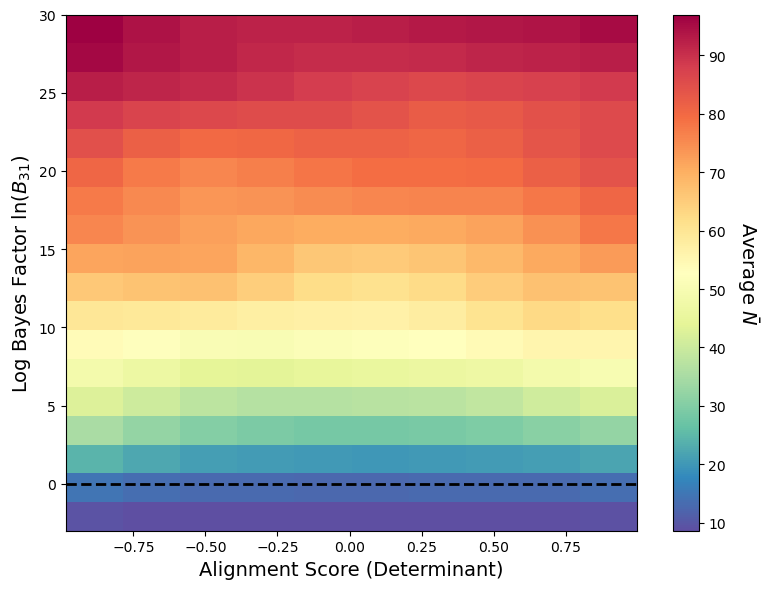

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
n_bins_x = 10
n_bins_y = 18

# Define bin edges for x and y
x_edges = np.linspace(B_31_df['determinant'].min(), B_31_df['determinant'].max(), n_bins_x + 1)
y_edges = np.linspace(-3, 30, n_bins_y + 1)

# Initialize array to hold average N_bar per 2D bin
Z = np.full((n_bins_y, n_bins_x), np.nan)  # shape: (y_bins, x_bins)

# Extract data arrays
x = B_31_df['determinant'].values
y = B_31_df['bayes_factor'].values
c = B_31_df['N_bar'].values

# Digitize points to find bin indices
x_bin_indices = np.digitize(x, x_edges) - 1  # subtract 1 to get zero-based indices
y_bin_indices = np.digitize(y, y_edges) - 1

# Filter out-of-range indices (can happen on right edge)
valid = (x_bin_indices >= 0) & (x_bin_indices < n_bins_x) & (y_bin_indices >= 0) & (y_bin_indices < n_bins_y)
x_bin_indices = x_bin_indices[valid]
y_bin_indices = y_bin_indices[valid]
c = c[valid]

# Create a 2D structure to collect values per bin for averaging
from collections import defaultdict
bin_values = defaultdict(list)
# Aggregate N_bar values in each bin
for xb, yb, val in zip(x_bin_indices, y_bin_indices, c):
    bin_values[(yb, xb)].append(val)
# Compute average N_bar per bin
for (yb, xb), values in bin_values.items():
    Z[yb, xb] = np.mean(values)

Z_smooth = gaussian_filter(Z, sigma=1)

# Create meshgrid for bin edges (for pcolormesh, edges needed)
X, Y = np.meshgrid(x_edges, y_edges)

# Plot heatmap
plt.figure(figsize=(8,6))
pcm = plt.pcolormesh(X, Y, Z_smooth, shading='auto', cmap=cmap)
cbar = plt.colorbar(pcm)
cbar.set_label(r'Average $\bar{N}$', rotation=270, labelpad=25, fontsize=14)

plt.xlabel('Alignment Score (Determinant)', fontsize=14)
plt.ylabel(r'Log Bayes Factor ln($B_{31}$)', fontsize=14)
plt.axhline(0, color='k', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

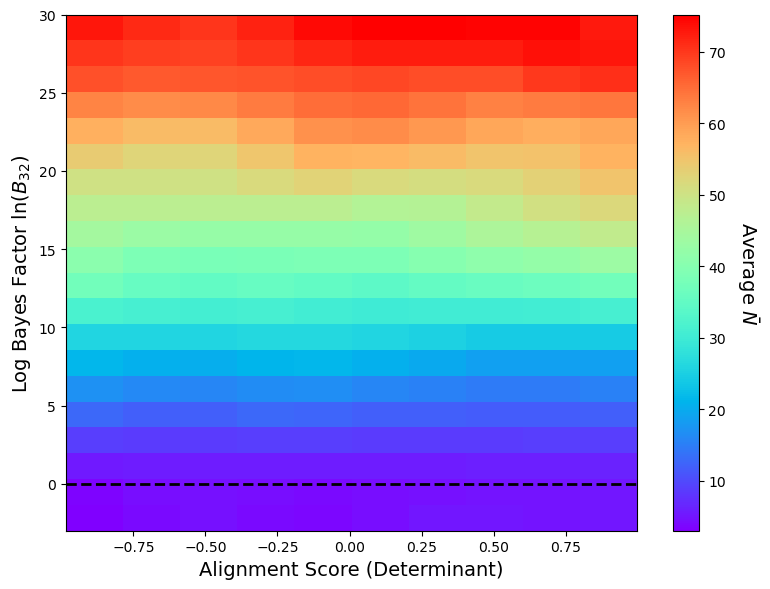

In [365]:
n_bins_x = 10
n_bins_y = 20

# Define bin edges for x and y
x_edges = np.linspace(B_32_df['determinant'].min(), B_32_df['determinant'].max(), n_bins_x + 1)
y_edges = np.linspace(-3, 30, n_bins_y + 1)

# Initialize array to hold average N_bar per 2D bin
Z = np.full((n_bins_y, n_bins_x), np.nan)  # shape: (y_bins, x_bins)

# Extract data arrays
x = B_32_df['determinant'].values
y = B_32_df['bayes_factor'].values
c = B_32_df['N_bar'].values

# Digitize points to find bin indices
x_bin_indices = np.digitize(x, x_edges) - 1  # subtract 1 to get zero-based indices
y_bin_indices = np.digitize(y, y_edges) - 1

# Filter out-of-range indices (can happen on right edge)
valid = (x_bin_indices >= 0) & (x_bin_indices < n_bins_x) & (y_bin_indices >= 0) & (y_bin_indices < n_bins_y)
x_bin_indices = x_bin_indices[valid]
y_bin_indices = y_bin_indices[valid]
c = c[valid]

# Create a 2D structure to collect values per bin for averaging
from collections import defaultdict
bin_values = defaultdict(list)
# Aggregate N_bar values in each bin
for xb, yb, val in zip(x_bin_indices, y_bin_indices, c):
    bin_values[(yb, xb)].append(val)
# Compute average N_bar per bin
for (yb, xb), values in bin_values.items():
    Z[yb, xb] = np.mean(values)

Z_smooth = gaussian_filter(Z, sigma=1)

# Create meshgrid for bin edges (for pcolormesh, edges needed)
X, Y = np.meshgrid(x_edges, y_edges)

# Plot heatmap
plt.figure(figsize=(8,6))
pcm = plt.pcolormesh(X, Y, Z_smooth, shading='auto', cmap='rainbow')
cbar = plt.colorbar(pcm)
cbar.set_label(r'Average $\bar{N}$', rotation=270, labelpad=25, fontsize=14)
plt.xlabel('Alignment Score (Determinant)', fontsize=14)
plt.ylabel(r'Log Bayes Factor ln($B_{32}$)', fontsize=14)
plt.axhline(0, color='k', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

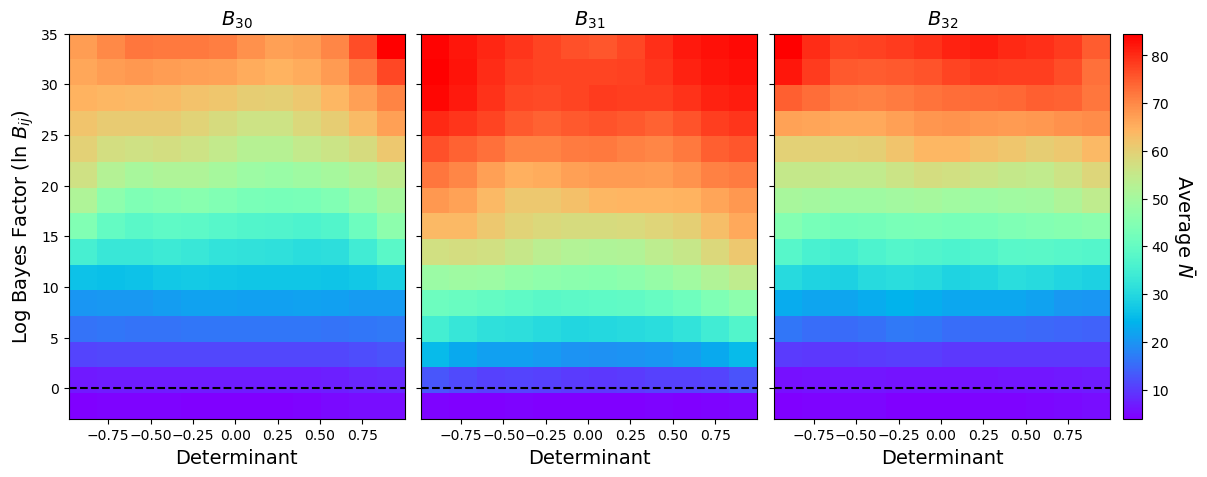

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
from collections import defaultdict

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05})
dfs = [B_30_df, B_31_df, B_32_df]
titles = [r"$B_{30}$", r"$B_{31}$", r"$B_{32}$"]

n_bins_x = 12
n_bins_y = 15
x_edges = np.linspace(B_30_df['determinant'].min(), B_30_df['determinant'].max(), n_bins_x + 1)
y_edges = np.linspace(-3, 35, n_bins_y + 1)
X, Y = np.meshgrid(x_edges, y_edges)

vmin, vmax = None, None  # Let color range auto-scale across all plots; you can set fixed vmin/vmax if needed

for ax, df, title in zip(axs, dfs, titles):
    # Prepare bin matrix
    Z = np.full((n_bins_y, n_bins_x), np.nan)

    # Digitize
    x = df['determinant'].values
    y = df['bayes_factor'].values
    c = df['N_bar'].values
    x_bin_indices = np.digitize(x, x_edges) - 1
    y_bin_indices = np.digitize(y, y_edges) - 1
    valid = (x_bin_indices >= 0) & (x_bin_indices < n_bins_x) & (y_bin_indices >= 0) & (y_bin_indices < n_bins_y)
    x_bin_indices = x_bin_indices[valid]
    y_bin_indices = y_bin_indices[valid]
    c = c[valid]

    bin_values = defaultdict(list)
    for xb, yb, val in zip(x_bin_indices, y_bin_indices, c):
        bin_values[(yb, xb)].append(val)
    for (yb, xb), values in bin_values.items():
        Z[yb, xb] = np.mean(values)

    Z_smooth = gaussian_filter(Z, sigma=1)

    pcm = ax.pcolormesh(X, Y, Z_smooth, shading='auto', cmap='rainbow', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=14)
    ax.axhline(0, color='k', linestyle='--', linewidth=1.5)
    # ax.axhline(np.log(30), color='r', linestyle='--', linewidth=1.5)

    # Axis labels and ticks
    if ax == axs[0]:
        ax.set_ylabel(r'Log Bayes Factor (ln $B_{ij}$)', fontsize=14)

    ax.set_xlabel('Determinant', fontsize=14)

# Add colorbar to far right
cbar = fig.colorbar(pcm, ax=axs, location='right', shrink=1, pad=0.01)
cbar.set_label(r'Average $\bar{N}$', rotation=270, labelpad=20, fontsize=14)

# plt.savefig('../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/dipole_quadrupole_model/Figures/bayes_factors_heatmaps.png', dpi=300)
# plt.tight_layout()
plt.show()

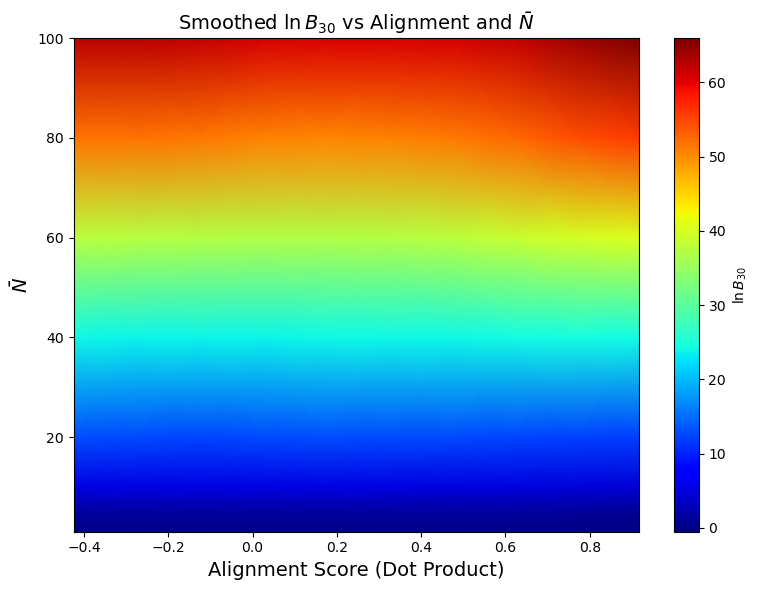

In [289]:
# import gaussian_filter
from scipy.ndimage import gaussian_filter
n_bins = 10
raw_bins = np.linspace(alignment_dataframe['raw_alignment'].min(),
                       alignment_dataframe['raw_alignment'].max(), n_bins + 1)
bin_centers = 0.5 * (raw_bins[:-1] + raw_bins[1:])
Z = np.full((len(N_bars), n_bins), np.nan)

# Fill Z with binned Bayes factor values
for i, N_bar in enumerate(N_bars):
    df_N = B_30_df[B_30_df['N_bar'] == N_bar].copy()
    df_N['bin'] = pd.cut(df_N['raw_alignment'], bins=raw_bins, labels=False, include_lowest=True)
    grouped = df_N.groupby('bin')['bayes_factor'].mean()

    for bin_idx, val in grouped.items():
        if pd.notna(val):
            Z[i, int(bin_idx)] = val

# --- Interpolate missing NaNs (optional but helps smoothing) ---
from scipy import interpolate

# Interpolate each row (per N_bar)
for i in range(Z.shape[0]):
    row = Z[i]
    x = np.where(~np.isnan(row))[0]
    y = row[~np.isnan(row)]
    if len(x) > 1:  # Only interpolate if enough points
        f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
        Z[i] = f(np.arange(len(row)))

# --- Apply Gaussian smoothing ---
Z_smooth = gaussian_filter(Z, sigma=1)

# --- Plot the smooth heatmap ---
X, Y = np.meshgrid(bin_centers, N_bars)
plt.figure(figsize=(8,6))
c = plt.pcolormesh(X, Y, Z_smooth, shading='gouraud', cmap='jet')
plt.colorbar(c, label=r'$\ln B_{30}$')
plt.xlabel('Alignment Score (Dot Product)', fontsize=14)
plt.ylabel(r'$\bar{N}$', fontsize=14)
plt.title(r'Smoothed $\ln B_{30}$ vs Alignment and $\bar{N}$', fontsize=14)
plt.tight_layout()
plt.show()